Importing the required libraries  

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tqdm import tqdm    # Progress bar

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

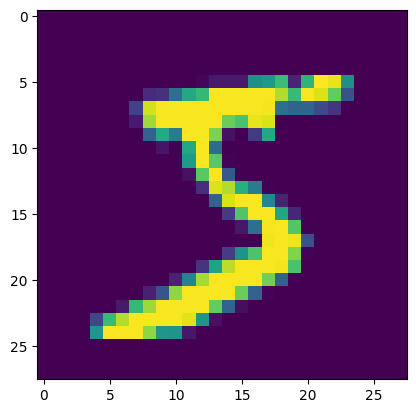

In [6]:
plt.imshow(x_train[0, :, :])
plt.show()

In [7]:
print(y_train[0])

5


In [8]:
def load_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train/255.0

  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train, x_test, y_test)

Creating the generator

In [9]:
def create_generator():
  generator = Sequential()
  generator.add(Dense(512, input_dim=784, activation='relu', name="hidden_1"))  # 28 * 28 = 784
  generator.add(Dense(512, activation='relu', name="hidden_2"))
  generator.add(Dense(1024, activation='relu', name="hidden_3"))
  generator.add(Dense(784, activation='tanh', name="output"))  # To genrate the image of 28*28 (=784)
  generator.compile(loss='binary_crossentropy', optimizer='adam')
  return generator

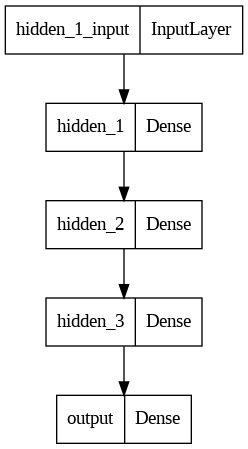

In [10]:
g = create_generator()
from tensorflow.keras.utils import plot_model

plot_model(g)

In [11]:
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 512)               401920    
                                                                 
 hidden_2 (Dense)            (None, 512)               262656    
                                                                 
 hidden_3 (Dense)            (None, 1024)              525312    
                                                                 
 output (Dense)              (None, 784)               803600    
                                                                 
Total params: 1993488 (7.60 MB)
Trainable params: 1993488 (7.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Creating the Discriminator

In [12]:
from tensorflow.keras.layers import LeakyReLU

In [13]:
def create_discriminator():
  discriminator = Sequential()
  discriminator.add(Dense(1024, input_dim = 784))  # 28 * 28 = 784
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(1, activation='sigmoid'))

  discriminator.compile(loss='binary_crossentropy', optimizer='adam')

  return discriminator


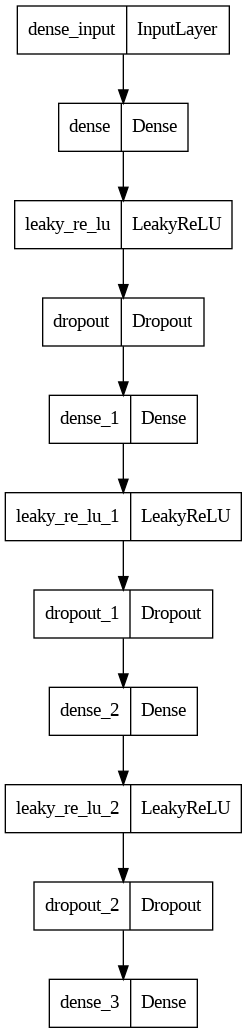

In [14]:
d = create_discriminator()
plot_model(d)

In [15]:
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)              

Creating the GAN

In [16]:
from tensorflow.keras.models import Model

In [17]:
def create_gan(discriminator, generator):
  discriminator.trainable = False
  gan_input = Input(shape=(784, ))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss='binary_crossentropy', optimizer='adam')
  return gan

In [18]:
gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1993488   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 3453713 (13.17 MB)
Trainable params: 1993488 (7.60 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


In [19]:
def training(generator, discriminator, gan, epochs=1, batch_size=128):

  (x_train, y_train, x_test, y_test) = load_data()
  batch_count = x_train.shape[0]/batch_size
  print(batch_count)

  print('Hai')
  for e in range(1, epochs+1):
    print('Epoch %d' %e)

    for _ in tqdm(range(batch_size)):
      noise = np.random.normal(0, 1, [batch_size, 784])

      generator_image = generator.predict(noise)

      image_batch = x_train[np.random.randint(low=0, high=x_train.shape[0], size=batch_size)]
      x = np.concatenate([image_batch, generator_image])

      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 1

      discriminator.trainabel = True
      discriminator.train_on_batch(x, y_dis)

      noise = np.random.normal(0, 1, [batch_size, 784])
      y_gen = np.ones(batch_size)

      discriminator.trainable=False
      gan.train_on_batch(noise, y_gen)


In [20]:
training(g, d, gan, epochs=1000, batch_size=128)

468.75
Hai
Epoch 1


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 1s 4ms/step


  1%|          | 1/128 [00:06<12:56,  6.11s/it]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:06<05:25,  2.58s/it]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:06<03:01,  1.45s/it]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:06<01:54,  1.08it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:06<01:19,  1.55it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:06<00:57,  2.14it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:06<00:42,  2.84it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:06<00:35,  3.42it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:07<00:27,  4.25it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:07<00:23,  5.10it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:07<00:19,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:07<00:17,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:07<00:16,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:07<00:17,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:07<00:17,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:08<00:18,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:08<00:16,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:08<00:15,  7.27it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 19/128 [00:08<00:14,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:08<00:13,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:08<00:12,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:08<00:12,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:08<00:12,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:09<00:12,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:09<00:12,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:09<00:13,  7.61it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:09<00:11,  8.90it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:09<00:09, 10.15it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:09<00:09, 10.66it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:09<00:08, 10.87it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:10<00:08, 11.04it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:10<00:07, 11.33it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:10<00:07, 11.78it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:10<00:07, 11.90it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:10<00:07, 11.34it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:11<00:07, 11.28it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:11<00:07, 11.28it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:11<00:06, 11.69it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:11<00:06, 11.91it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:11<00:06, 11.80it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:11<00:06, 11.85it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:12<00:05, 11.82it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:12<00:06, 10.70it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:12<00:06, 10.80it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:12<00:05, 11.12it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:12<00:05, 11.27it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:12<00:05, 11.35it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:13<00:05, 11.27it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:13<00:04, 11.35it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:13<00:04, 11.57it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:13<00:04, 11.81it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:13<00:04, 11.72it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:13<00:04, 11.81it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:14<00:03, 11.82it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:14<00:03, 11.21it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:14<00:03, 11.41it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:14<00:03, 11.64it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:14<00:03, 11.51it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:14<00:03, 11.80it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:15<00:02, 11.63it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:15<00:02, 11.64it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:15<00:02, 11.90it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:15<00:02, 12.02it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:15<00:02, 11.86it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:02, 11.74it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:16<00:01, 11.54it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:01, 11.63it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:16<00:01, 11.72it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:16<00:01, 11.84it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:16<00:01, 12.01it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:17<00:00, 12.12it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:17<00:00, 12.13it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:17<00:00, 11.87it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:17<00:00, 11.83it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:17<00:00, 12.00it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:17<00:00, 11.64it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:18<00:00,  7.09it/s]


Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:12, 10.47it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:11, 11.12it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:10, 11.52it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:10, 11.87it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:09, 11.98it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:01<00:09, 12.00it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:01<00:10, 11.19it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:01<00:12,  9.14it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:13,  8.51it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:12,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:01<00:12,  8.47it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:02<00:12,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:12,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:14,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:02<00:13,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:02<00:12,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:12,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:02<00:12,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:13,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:03<00:13,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:03<00:14,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:13,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:03<00:12,  7.63it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 33/128 [00:03<00:12,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:03<00:12,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:11,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:11,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:10,  8.49it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:04<00:10,  8.65it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 39/128 [00:04<00:10,  8.73it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:04<00:09,  8.89it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:09,  8.92it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:04<00:09,  8.97it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:09,  8.69it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:05<00:10,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:10,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:05<00:10,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:05<00:11,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:10,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:08,  9.28it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:07,  9.89it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:06<00:06, 10.72it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:06, 11.28it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:06<00:06, 11.43it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:06<00:05, 11.52it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:06<00:05, 11.69it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:06<00:05, 11.80it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:07<00:05, 11.84it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:07<00:05, 11.95it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:07<00:04, 11.64it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:07<00:04, 11.51it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:07<00:04, 11.68it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:07<00:04, 11.84it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:08<00:04, 11.90it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:08<00:03, 12.03it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:08<00:03, 11.92it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:08<00:03, 11.80it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:08<00:03, 11.81it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:08<00:03, 11.87it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:09<00:03, 11.92it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:09<00:03, 11.84it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:09<00:02, 11.98it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:09<00:02, 11.62it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:09<00:02, 11.55it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:09<00:02, 11.84it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:10<00:02, 11.95it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:10<00:01, 12.05it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:10<00:01, 12.23it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:10<00:01, 12.21it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:10<00:01, 12.14it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:10<00:01, 12.00it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:11<00:01, 11.93it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:11<00:01, 11.59it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:11<00:00, 11.79it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:11<00:00, 11.67it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:11<00:00, 11.47it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:11<00:00, 11.49it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:12<00:00, 11.68it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:12<00:00, 10.38it/s]


Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:10, 11.93it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:10, 11.33it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:10, 11.35it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:10, 11.70it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:10, 11.74it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:09, 11.94it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:09, 11.92it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:09, 11.76it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:09, 11.92it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:09, 11.25it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:09, 11.00it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:09, 10.69it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:02<00:09, 11.07it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:08, 11.14it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:02<00:08, 11.46it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:02<00:08, 11.70it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:11,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:11,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:03<00:11,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:03<00:11,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:03<00:11,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:03<00:12,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:11,  7.53it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 41/128 [00:04<00:11,  7.89it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:04<00:10,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:10,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:04<00:11,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:04<00:11,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:11,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:04<00:11,  7.03it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:05<00:10,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:05<00:11,  7.12it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:10,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:05<00:10,  7.60it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:10,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:05<00:10,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:05<00:09,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:09,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:08,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:08,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:08,  8.57it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:06<00:08,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:06<00:08,  7.68it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 61/128 [00:06<00:08,  7.74it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:06<00:08,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:08,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:09,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:07<00:08,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:07<00:08,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:07<00:08,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:07<00:06,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:07<00:06,  9.45it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:08<00:05, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:08<00:04, 10.89it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:08<00:04, 10.97it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:08<00:04, 10.96it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:08<00:04, 11.14it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:08<00:03, 11.42it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:09<00:03, 11.63it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:09<00:03, 11.94it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:09<00:03, 11.73it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:09<00:03, 11.57it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:09<00:03, 11.66it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:10<00:02, 11.41it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:10<00:02, 11.54it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:10<00:02, 11.48it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:10<00:02, 11.33it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:10<00:02, 10.93it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:10<00:02, 10.93it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:11<00:01, 11.31it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:11<00:01, 11.51it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:11<00:01, 11.64it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:11<00:01, 11.61it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 115/128 [00:11<00:01, 11.64it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:11<00:00, 11.76it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 119/128 [00:12<00:00, 11.78it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:12<00:00, 11.89it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:12<00:00, 11.92it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:12<00:00, 11.76it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:12<00:00, 10.71it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:12<00:00,  9.91it/s]


Epoch 4


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:11, 11.27it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:10, 11.74it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:10, 11.76it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:10, 11.69it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:10, 11.54it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:09, 11.70it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:10, 11.36it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:09, 11.62it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:09, 11.51it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:09, 11.41it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:09, 11.26it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:09, 11.10it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:08, 11.34it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:08, 11.57it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:02<00:09, 10.66it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:02<00:08, 10.68it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:08, 11.02it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:08, 11.19it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:03<00:07, 11.60it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:03<00:07, 11.46it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:03<00:07, 11.64it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:03<00:07, 11.54it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:07, 11.55it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:04<00:06, 11.46it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:04<00:06, 11.56it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:04<00:06, 11.73it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:04<00:07, 10.41it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:05<00:07,  9.37it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:05<00:07,  9.09it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:05<00:08,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:05<00:08,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:05<00:08,  7.81it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 61/128 [00:05<00:08,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:05<00:08,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:05<00:08,  7.94it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:06<00:07,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:06<00:08,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:06<00:07,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:06<00:08,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:06<00:07,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:06<00:07,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:06<00:07,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:07<00:07,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:07<00:07,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:07<00:08,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:07<00:08,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:07<00:07,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:07<00:07,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:07<00:07,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:08<00:06,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:08<00:06,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:08<00:06,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:08<00:06,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:08<00:06,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:08<00:06,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:08<00:05,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:08<00:05,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:09<00:05,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:09<00:04,  8.72it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:09<00:03,  9.65it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:09<00:03, 10.27it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:09<00:03, 10.86it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:09<00:02, 11.10it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:10<00:02, 10.98it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:10<00:02, 11.33it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:10<00:02, 11.59it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:10<00:02, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:10<00:01, 11.00it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:11<00:01, 11.15it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:11<00:01, 11.18it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:11<00:01, 11.53it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:11<00:01, 11.49it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:11<00:01, 11.46it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:11<00:00, 10.99it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:12<00:00, 10.44it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:12<00:00, 10.95it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:12<00:00, 11.26it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:12<00:00, 11.34it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:12<00:00,  9.95it/s]


Epoch 5


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:11, 11.17it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:10, 11.53it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:10, 11.17it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:10, 11.27it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:10, 11.25it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:10, 11.00it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:10, 11.06it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:10, 11.17it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:09, 11.22it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:09, 11.21it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:09, 11.40it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:02<00:09, 11.52it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:08, 11.58it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:08, 11.47it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:02<00:08, 11.58it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:02<00:08, 11.59it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:02<00:08, 11.64it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:07, 11.55it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:03<00:07, 11.58it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:03<00:07, 11.53it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:03<00:07, 11.66it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:03<00:07, 11.59it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:07, 10.92it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:04<00:07, 11.18it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:04<00:06, 11.30it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:04<00:06, 10.99it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:04<00:06, 11.20it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:04<00:06, 11.33it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:05<00:06, 10.96it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:05<00:06, 11.24it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:05<00:06, 10.44it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:05<00:05, 10.80it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:05<00:05, 11.09it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:06<00:05, 10.54it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:06<00:05, 10.13it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:06<00:06,  9.02it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 73/128 [00:06<00:06,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:06<00:06,  8.71it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:06<00:06,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:07<00:06,  7.85it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 77/128 [00:07<00:06,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:07<00:06,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:07<00:06,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:07<00:06,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:07<00:06,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:07<00:06,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:08<00:06,  6.87it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:08<00:05,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:08<00:05,  7.81it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:08<00:05,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:08<00:05,  7.88it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:08<00:05,  7.41it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 89/128 [00:08<00:05,  7.69it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:08<00:05,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:09<00:04,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:09<00:05,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:09<00:04,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:09<00:04,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:09<00:04,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:09<00:04,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:09<00:04,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:10<00:04,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:10<00:04,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:10<00:04,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:10<00:04,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:10<00:03,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:10<00:02,  9.20it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:11<00:02,  9.52it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:11<00:01,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:11<00:01, 10.40it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:11<00:01, 10.75it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:11<00:01, 11.04it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:12<00:01, 10.37it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:12<00:00, 10.91it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:12<00:00, 11.21it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:12<00:00, 11.50it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:12<00:00, 10.98it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:12<00:00, 11.19it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:13<00:00,  9.81it/s]


Epoch 6


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:11, 11.38it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:10, 11.91it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:10, 11.98it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:00<00:11, 10.75it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:10, 10.81it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:01<00:10, 11.17it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:10, 11.30it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:09, 11.52it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:09, 11.49it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:09, 10.93it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:09, 10.73it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:09, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:09, 11.10it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:08, 11.22it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:02<00:09, 10.60it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:02<00:08, 10.87it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:08, 11.05it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:08, 11.03it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:03<00:08, 11.13it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:03<00:07, 11.24it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:03<00:07, 11.26it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:03<00:07, 11.51it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:07, 11.71it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:04<00:06, 11.58it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:04<00:06, 11.66it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:04<00:06, 11.67it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:04<00:07, 10.37it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:05<00:06, 10.80it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:05<00:06, 10.99it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:05<00:05, 11.33it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:05<00:05, 11.37it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:05<00:05, 11.54it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:05<00:05, 11.03it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:06<00:05, 10.89it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:06<00:05, 11.19it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:06<00:04, 11.37it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:06<00:04, 11.50it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:06<00:04, 11.47it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:06<00:04, 11.27it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:07<00:04, 11.32it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:07<00:03, 11.58it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:07<00:03, 11.71it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:07<00:03, 10.93it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:07<00:04,  9.79it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:08<00:04,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:08<00:04,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:08<00:04,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:08<00:04,  7.88it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:08<00:04,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:08<00:04,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:09<00:04,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:09<00:04,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:09<00:04,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:09<00:03,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:09<00:03,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:09<00:03,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:09<00:03,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:10<00:03,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:10<00:03,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:10<00:03,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:10<00:03,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:10<00:03,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:10<00:02,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:10<00:02,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:11<00:02,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:11<00:02,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:11<00:02,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:11<00:01,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:11<00:01,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:11<00:01,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:11<00:01,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:12<00:01,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:12<00:01,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:12<00:01,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:12<00:00,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:12<00:00,  9.76it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:12<00:00, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:12<00:00, 10.54it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:13<00:00,  9.78it/s]


Epoch 7


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:11, 11.08it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:10, 11.40it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:10, 11.74it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:10, 11.55it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:10, 11.43it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:10, 11.23it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:10, 11.34it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:10, 11.12it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:09, 11.19it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:09, 11.07it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:09, 11.19it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:09, 11.33it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:08, 11.42it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:08, 11.52it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:02<00:08, 11.37it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:02<00:08, 11.49it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:02<00:08, 11.67it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:08, 11.25it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:03<00:08, 11.25it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:03<00:08, 10.19it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:03<00:08, 10.64it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:03<00:07, 10.64it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:07, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:04<00:07, 11.00it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:04<00:07, 10.54it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:04<00:07, 10.61it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:04<00:06, 10.98it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:05<00:06, 11.08it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:05<00:06, 10.45it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:05<00:06, 10.30it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:05<00:06, 10.78it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:05<00:05, 10.78it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:05<00:05, 10.73it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:06<00:05, 10.77it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:06<00:05, 11.07it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:06<00:05, 11.16it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:06<00:05, 10.66it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:06<00:04, 10.61it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:07<00:04, 10.85it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:07<00:04, 10.82it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:07<00:04, 11.00it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:07<00:03, 11.16it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:07<00:03, 11.25it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:07<00:03, 11.20it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:08<00:03, 11.26it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:08<00:03, 11.19it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:08<00:03, 11.07it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:08<00:03, 10.40it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:08<00:03,  9.94it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:09<00:02,  9.49it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:09<00:02,  9.25it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:09<00:02,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:09<00:02,  8.43it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████▏ | 104/128 [00:09<00:04,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:10<00:04,  4.75it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:10<00:04,  5.05it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:10<00:03,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:10<00:04,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:11<00:05,  3.74it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:11<00:04,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 111/128 [00:11<00:03,  5.05it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:11<00:02,  5.74it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:11<00:02,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:12<00:03,  3.68it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:12<00:03,  4.14it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:12<00:02,  4.63it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:12<00:02,  5.21it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:12<00:01,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:13<00:01,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:13<00:01,  6.76it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 121/128 [00:13<00:01,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:13<00:00,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:13<00:00,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:13<00:00,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:13<00:00,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:14<00:00,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:14<00:00,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:14<00:00,  8.94it/s]


Epoch 8


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:13,  9.51it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:11, 10.74it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:10, 11.10it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:10, 11.19it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:10, 11.28it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:10, 11.46it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:10, 11.17it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:10, 11.15it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:09, 11.27it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:09, 11.29it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:09, 11.43it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:09, 10.72it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:10, 10.11it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:09, 10.47it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:02<00:09, 10.38it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:02<00:08, 10.80it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:08, 11.10it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:03<00:08, 10.54it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:03<00:08, 10.82it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:03<00:08, 10.97it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:03<00:08, 10.40it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:07, 10.76it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:07, 11.03it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:04<00:07, 10.99it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:04<00:07, 11.11it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:04<00:06, 11.22it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:04<00:06, 11.32it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:05<00:06, 11.12it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:05<00:06, 11.08it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:05<00:06, 10.69it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:05<00:06, 10.91it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:05<00:05, 10.90it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:06<00:05, 11.12it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:06<00:05, 10.34it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:06<00:05, 10.48it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:06<00:05, 10.81it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:06<00:04, 11.15it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:06<00:04, 11.33it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:07<00:04, 11.06it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:07<00:04, 11.21it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:07<00:04, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:07<00:04, 10.45it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:07<00:03, 10.83it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:08<00:03, 10.72it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:08<00:03, 11.07it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:08<00:03, 10.33it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:08<00:03, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:08<00:02, 10.96it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:09<00:02, 10.97it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:09<00:02, 11.14it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:09<00:02, 10.87it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:09<00:02, 10.88it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:09<00:01, 11.12it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:09<00:01, 10.78it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:10<00:01,  9.83it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:10<00:01,  9.42it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:10<00:01,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:10<00:01,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:10<00:01,  8.41it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:10<00:01,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:11<00:01,  7.75it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:11<00:01,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:11<00:01,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:11<00:01,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:11<00:00,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:11<00:00,  7.40it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 123/128 [00:11<00:00,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:12<00:00,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:12<00:00,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:12<00:00,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:12<00:00,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:12<00:00, 10.21it/s]


Epoch 9


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:20,  6.09it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:17,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:16,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:16,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:16,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:17,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:17,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:17,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:16,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:01<00:15,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:15,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:14,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:16,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:16,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:13,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:13,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:11,  9.20it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:10,  9.90it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:09, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:09, 10.31it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:09, 10.52it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:08, 10.76it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:08, 11.11it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:08, 10.70it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:08, 10.55it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:08, 10.77it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:07, 10.94it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:07, 10.96it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:05<00:08,  9.99it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:07, 10.12it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:07, 10.05it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:07, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:05<00:07,  9.91it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:06, 10.29it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:06, 10.61it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:06<00:06, 10.60it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:06<00:06, 10.54it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:06<00:06, 10.18it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:07<00:05, 10.55it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:07<00:05, 10.83it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:07<00:05, 10.53it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:07<00:05, 10.56it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:07<00:04, 10.85it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:07<00:04, 10.76it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:08<00:04, 10.96it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:08<00:04, 10.99it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:08<00:04, 10.91it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:08<00:03, 11.00it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:08<00:03, 11.02it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:09<00:03, 11.08it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:09<00:03, 11.20it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:09<00:03, 10.65it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:09<00:03, 10.81it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:09<00:03, 10.65it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:09<00:02, 10.84it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:10<00:02, 10.46it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:10<00:02, 10.69it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:10<00:02, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:10<00:02, 10.65it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:10<00:01, 10.59it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:11<00:01, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:11<00:01, 10.09it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:11<00:01, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:11<00:01, 10.13it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:11<00:00, 10.48it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:12<00:00, 10.04it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:12<00:00, 10.49it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:12<00:00,  8.67it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:12<00:00,  8.52it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:12<00:00,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:13<00:00,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:13<00:00,  9.69it/s]


Epoch 10


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:19,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:17,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:18,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:17,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:17,  7.11it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:01<00:16,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:16,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:16,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:16,  7.06it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:01<00:16,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:16,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:15,  7.19it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:15,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:16,  6.56it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 20/128 [00:02<00:16,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:16,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:15,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:15,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:15,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:14,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:03<00:15,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:14,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:11,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:10,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:10,  9.09it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:09,  9.84it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:08, 10.23it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:09,  9.75it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:08, 10.16it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:05<00:08, 10.46it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:08, 10.00it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:08,  9.98it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:06<00:07, 10.30it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:06<00:07, 10.65it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:06<00:06, 10.86it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:06<00:07, 10.19it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:06, 10.53it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:07<00:06, 10.77it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:07<00:06, 10.94it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:05, 11.11it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:07<00:05, 10.88it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:07<00:05, 10.35it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:07<00:05, 10.55it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:08<00:05, 10.77it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:08<00:05, 10.94it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:08<00:04, 11.02it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:08<00:04, 10.50it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:08<00:04, 10.59it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 81/128 [00:09<00:04, 10.75it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:09<00:04, 11.03it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:09<00:03, 11.02it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:09<00:03, 11.13it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:09<00:03, 10.93it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:09<00:03, 10.89it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:10<00:03, 10.75it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:10<00:03, 10.84it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:10<00:02, 10.92it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:10<00:02, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:10<00:02, 10.90it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:11<00:02, 11.11it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:11<00:02, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:11<00:01, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:11<00:01, 10.17it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:11<00:01,  9.92it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:12<00:01, 10.33it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:12<00:01,  9.72it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:12<00:01,  9.60it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:12<00:01,  9.97it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:12<00:00, 10.38it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:12<00:00, 10.28it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:13<00:00, 10.35it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:13<00:00,  9.96it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:13<00:00,  9.44it/s]


Epoch 11


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:13,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:12,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:12,  9.73it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:13,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:14,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:14,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:14,  8.02it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:01<00:15,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:29,  4.02it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:25,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:23,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:22,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:21,  5.35it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:18,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:17,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:17,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:16,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:15,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.29it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:16,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:04<00:15,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:15,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:04<00:16,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:15,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:04<00:15,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:05<00:14,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:11,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:11,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:11,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:10,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:10,  8.74it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:09,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:09,  9.35it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:08,  9.52it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:08,  9.46it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:08,  9.80it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:06<00:07, 10.05it/s]

4/4 [==============================] - 0s 2ms/step


 40%|███▉      | 51/128 [00:07<00:07,  9.98it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:07<00:07,  9.96it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:07<00:07, 10.24it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:07<00:06, 10.56it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:07<00:06, 10.15it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:07<00:06, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:08<00:06, 10.32it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:08<00:06, 10.18it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:08<00:06,  9.98it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 67/128 [00:08<00:06,  9.87it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:08<00:05, 10.18it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:09<00:06,  9.48it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:09<00:05,  9.88it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:09<00:05,  9.68it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:09<00:05,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:09<00:04, 10.14it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:09<00:04,  9.68it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:10<00:04,  9.58it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:10<00:04,  9.94it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:10<00:04, 10.25it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:10<00:03, 10.35it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:10<00:03, 10.39it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:10<00:03, 10.44it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:11<00:03, 10.72it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:11<00:03, 10.65it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:11<00:02, 10.61it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:11<00:02, 10.48it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:11<00:02, 10.73it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 103/128 [00:12<00:02, 10.86it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 105/128 [00:12<00:02, 10.68it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:12<00:01, 10.83it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 109/128 [00:12<00:01, 10.34it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:12<00:01, 10.16it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:13<00:01, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:13<00:01, 10.27it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:13<00:01, 10.60it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:13<00:00, 10.81it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:13<00:00, 10.81it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:13<00:00, 10.96it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:14<00:00, 10.57it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:14<00:00, 10.78it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:14<00:00,  8.85it/s]


Epoch 12


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:13,  9.54it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:11, 10.54it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:12,  9.63it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:12,  9.72it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:12,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:14,  8.26it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 9/128 [00:01<00:14,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:15,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:15,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:16,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:15,  7.20it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 15/128 [00:01<00:15,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:16,  6.62it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:02<00:16,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:16,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:16,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:16,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:02<00:15,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 23/128 [00:03<00:15,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:13,  7.36it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:03<00:14,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:13,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:13,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:13,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:12,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:12,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:12,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:12,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:04<00:13,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:12,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:12,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:12,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:11,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:12,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:11,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:11,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:05<00:11,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:05<00:11,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:05<00:11,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:10,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:09,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:06<00:08,  9.67it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:06<00:07, 10.13it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:06<00:07, 10.01it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:06<00:07, 10.44it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:07<00:07,  9.96it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:07<00:07,  9.80it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:07<00:06, 10.14it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:07<00:06, 10.04it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:07<00:06,  9.97it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:06,  9.82it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:06,  9.80it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:08<00:05, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:08<00:05, 10.76it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:05, 10.55it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:05, 10.46it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:08<00:05, 10.38it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:09<00:05, 10.01it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:09<00:04, 10.49it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:09<00:04, 10.64it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:09<00:04, 10.75it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:09<00:04, 10.44it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:09<00:03, 10.62it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:10<00:03, 10.85it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:10<00:03, 10.04it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:10<00:03, 10.05it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:10<00:03,  9.97it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:10<00:03, 10.01it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:11<00:02, 10.40it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:11<00:02, 10.64it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:11<00:02, 10.64it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:11<00:02, 10.57it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:11<00:02, 10.55it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:12<00:01, 10.66it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:12<00:01, 10.56it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:12<00:01, 10.09it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:12<00:01, 10.30it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:12<00:01, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:13<00:00, 10.60it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:13<00:00, 10.87it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:13<00:00, 11.02it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:13<00:00, 10.61it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:13<00:00, 10.73it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:13<00:00,  9.19it/s]


Epoch 13


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:13,  9.27it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:11, 10.77it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:12,  9.77it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:11, 10.31it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 9/128 [00:00<00:11, 10.40it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:11, 10.30it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:10, 10.68it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:11,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:11, 10.04it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:01<00:10, 10.35it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:10, 10.33it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:10,  9.57it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 24/128 [00:02<00:12,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:02<00:12,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:12,  7.89it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:02<00:13,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:12,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:13,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:13,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:13,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:13,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:13,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:12,  7.36it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:04<00:13,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:12,  7.31it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 37/128 [00:04<00:12,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:11,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:11,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:11,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:12,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 42/128 [00:04<00:12,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:05<00:12,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:05<00:12,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:05<00:12,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:05<00:11,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:11,  7.07it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:05<00:11,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:10,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:06<00:11,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:06<00:10,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:06<00:11,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:06<00:11,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:06<00:10,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:10,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:10,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:07<00:10,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:07<00:10,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:07<00:08,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:07<00:08,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:07,  8.88it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:08<00:06,  9.36it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:08<00:06,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:08<00:06,  9.26it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:08<00:06,  9.62it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:08<00:05,  9.77it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:05,  9.54it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:08<00:05,  9.99it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:09<00:05, 10.24it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:09<00:05,  9.55it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:09<00:04, 10.00it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:09<00:04, 10.12it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:09<00:04, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:10<00:04, 10.01it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:10<00:04,  9.86it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:10<00:03, 10.17it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:10<00:03, 10.27it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:10<00:03, 10.47it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:11<00:03, 10.63it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:11<00:02, 10.64it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:11<00:02, 10.75it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:11<00:02, 10.72it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:11<00:02, 10.85it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:11<00:02, 10.93it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:12<00:01, 11.02it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:12<00:01, 10.87it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:12<00:01, 10.79it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:12<00:01, 10.86it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:12<00:01, 10.87it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:13<00:00, 11.03it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:13<00:00, 11.12it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:13<00:00, 10.70it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:13<00:00, 10.37it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:13<00:00, 10.59it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:14<00:00,  9.13it/s]


Epoch 14


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:18,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:13,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:14,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:13,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:13,  8.91it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:12,  9.86it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:11, 10.37it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:11, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:10, 10.48it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:10, 10.25it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:10, 10.50it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:10, 10.45it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:10, 10.51it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:02<00:10, 10.13it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:09, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:09, 10.41it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:02<00:09, 10.71it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:03<00:08, 10.83it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:03<00:09,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:10,  9.20it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:11,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:03<00:11,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:03<00:11,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:04<00:12,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:12,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:12,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:12,  6.93it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 43/128 [00:04<00:12,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:04<00:12,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:12,  6.77it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:05<00:12,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:12,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:12,  6.61it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:05<00:12,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:11,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:11,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:06<00:11,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:06<00:11,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:06<00:10,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:06<00:11,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:10,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:06<00:10,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:11,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:07<00:10,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:07<00:10,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:07<00:09,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:07<00:09,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:10,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:09,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:08<00:09,  6.91it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:08<00:09,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:08<00:08,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:08<00:08,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:06,  8.65it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:08<00:06,  8.88it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:06,  9.06it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:09<00:05,  9.33it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:09<00:05,  9.85it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:09<00:05,  9.63it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:09<00:05,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:09<00:05,  9.30it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:09<00:05,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:10<00:04,  9.66it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:10<00:04,  9.61it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:10<00:04, 10.15it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:10<00:03, 10.38it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:10<00:03, 10.13it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:10<00:03, 10.28it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:11<00:03, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:11<00:02, 10.71it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:11<00:02, 10.11it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:11<00:02, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:11<00:02, 10.24it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:12<00:02, 10.35it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:12<00:02, 10.31it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:12<00:01, 10.13it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:12<00:01, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:12<00:01, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:13<00:01,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:13<00:01,  9.92it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:13<00:00, 10.17it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:13<00:00,  9.87it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:13<00:00,  9.62it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:13<00:00,  9.59it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:14<00:00, 10.11it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:14<00:00, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:14<00:00,  8.91it/s]


Epoch 15


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:13,  9.40it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:12, 10.24it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 5/128 [00:00<00:12,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:12,  9.97it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:00<00:11, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:10, 10.68it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:10, 10.66it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:10, 10.72it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:11, 10.08it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:01<00:10, 10.34it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:10, 10.47it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:10, 10.30it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:02<00:10, 10.23it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:02<00:09, 10.31it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:02<00:09, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:02<00:09, 10.67it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:09, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:08, 10.47it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:03<00:08, 10.40it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:03<00:08, 10.34it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:03<00:08, 10.46it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:09,  9.22it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 44/128 [00:04<00:09,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:04<00:10,  8.19it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:10,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:04<00:10,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:04<00:11,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:11,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:11,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:05<00:11,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:10,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:05<00:11,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:05<00:10,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:05<00:09,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:09,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:09,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:10,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:06<00:10,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:06<00:10,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:06<00:10,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:07<00:09,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:09,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:09,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:07<00:09,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:07<00:09,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:07<00:09,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:07<00:09,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:08<00:08,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:08,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:08<00:07,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:07,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:08<00:07,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:08<00:07,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:08<00:07,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:09<00:07,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:09<00:07,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:09<00:07,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:09<00:06,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:09<00:05,  8.68it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:09<00:05,  8.90it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 83/128 [00:09<00:04,  9.04it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:09<00:04,  9.14it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:10<00:04,  9.04it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:10<00:04,  9.68it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:10<00:04,  9.39it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:10<00:03,  9.98it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:10<00:03,  9.66it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:10<00:03,  9.54it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:11<00:03,  9.36it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:11<00:03,  9.75it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:11<00:02, 10.09it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:11<00:02, 10.00it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:11<00:02,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:11<00:02,  9.87it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:11<00:02,  9.67it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:12<00:02,  9.98it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:12<00:02,  9.96it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:12<00:01, 10.33it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:12<00:01, 10.49it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:12<00:01, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:12<00:01, 10.45it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:13<00:01, 10.16it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:13<00:00, 10.16it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:13<00:00, 10.10it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:13<00:00,  9.95it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:13<00:00, 10.10it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:14<00:00, 10.12it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:14<00:00,  8.91it/s]


Epoch 16


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:16,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:12,  9.84it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:12,  9.60it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:12, 10.14it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:12,  9.90it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:12,  9.86it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:11, 10.25it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:11, 10.49it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:11, 10.18it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:11, 10.16it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:10, 10.15it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:01<00:10, 10.32it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:10, 10.57it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:09, 10.49it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:09, 10.58it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:09, 10.34it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:02<00:10,  9.52it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:09,  9.89it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:09, 10.05it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:09, 10.21it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:03<00:09,  9.66it/s]

4/4 [==============================] - 0s 10ms/step


 30%|███       | 39/128 [00:03<00:10,  8.64it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███▏      | 40/128 [00:04<00:11,  7.34it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 41/128 [00:04<00:12,  6.82it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 42/128 [00:04<00:13,  6.40it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▎      | 43/128 [00:04<00:15,  5.37it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:14,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:13,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:05<00:13,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:12,  6.47it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:05<00:12,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:05<00:12,  6.43it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:05<00:12,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:11,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:06<00:11,  6.48it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:06<00:11,  6.57it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:06<00:11,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:10,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:10,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:06<00:10,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:07<00:10,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:07<00:10,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:07<00:10,  6.64it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 61/128 [00:07<00:10,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:07<00:09,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:07<00:09,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:09,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:08<00:09,  6.91it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:08<00:09,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:08<00:08,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:08<00:08,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:08<00:09,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:09,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:08<00:08,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:09<00:08,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:09<00:08,  6.69it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:09<00:07,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:09<00:07,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:09<00:08,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:09<00:07,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:10<00:07,  6.52it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:10<00:07,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:10<00:08,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:10<00:07,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:10<00:05,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:10<00:05,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:10<00:04,  8.69it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:10<00:04,  8.98it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:04,  9.47it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:11<00:04,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:11<00:04,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:11<00:03,  9.46it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:11<00:03,  9.35it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 95/128 [00:11<00:03,  9.82it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 97/128 [00:12<00:03, 10.04it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:12<00:03,  9.34it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:12<00:03,  9.31it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:12<00:02,  9.86it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:12<00:02, 10.05it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:12<00:02,  9.94it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:13<00:02, 10.29it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:13<00:01, 10.34it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:13<00:01, 10.52it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:13<00:01, 10.24it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:13<00:01, 10.31it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:14<00:01,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:14<00:01,  9.48it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:14<00:01,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:14<00:00,  9.30it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:14<00:00,  9.78it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:14<00:00,  9.78it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:14<00:00,  9.71it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:14<00:00,  9.71it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:15<00:00, 10.19it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:15<00:00,  8.37it/s]


Epoch 17


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:14,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:14,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:12,  9.56it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:11, 10.18it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:11, 10.12it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:00<00:11, 10.43it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:11, 10.51it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:10, 10.55it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:10, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:11,  9.26it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:01<00:11,  9.69it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:02<00:11,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:11,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:10,  9.85it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:10,  9.84it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:02<00:10,  9.85it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:10,  9.67it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:09, 10.23it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:09, 10.19it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:09,  9.81it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:09,  9.83it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:09,  9.63it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:09,  9.51it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 37/128 [00:03<00:09, 10.02it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:03<00:08, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:08, 10.46it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:04<00:08, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:04<00:08, 10.37it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:04<00:07, 10.24it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:04<00:07, 10.43it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:07, 10.23it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:05<00:08,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:05<00:08,  8.44it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 55/128 [00:05<00:09,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:05<00:09,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:05<00:09,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:09,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:06<00:09,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:06<00:09,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:06<00:09,  7.00it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:06<00:09,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:06<00:09,  7.02it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:06<00:09,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:07<00:08,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:07<00:08,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:07<00:08,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:07<00:08,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:07<00:08,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:07<00:08,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:08<00:08,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:08,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:08<00:08,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:08<00:08,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:08<00:08,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:08<00:07,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:08<00:07,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:09<00:06,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:09<00:06,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:09<00:06,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:09<00:06,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:09<00:06,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:09<00:06,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:09<00:06,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:09<00:05,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:10<00:05,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:10<00:05,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:10<00:05,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:10<00:05,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:10<00:05,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:10<00:04,  8.32it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 93/128 [00:11<00:04,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:11<00:03,  9.49it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:11<00:03,  9.83it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:11<00:03,  9.71it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:11<00:02,  9.77it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:11<00:02, 10.08it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:11<00:02, 10.01it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:11<00:02,  9.96it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:12<00:02,  9.66it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:12<00:02, 10.07it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:12<00:02,  9.53it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:12<00:01,  9.99it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:12<00:01,  9.95it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:12<00:01,  9.89it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:13<00:01,  9.76it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:13<00:01, 10.12it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:13<00:01,  9.43it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:13<00:01,  9.01it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:13<00:00,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:13<00:00,  9.35it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:13<00:00,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:14<00:00,  8.77it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:14<00:00,  9.56it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:14<00:00,  9.11it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:14<00:00,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:14<00:00,  8.73it/s]


Epoch 18


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:14,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:12, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:12,  9.85it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:12,  9.88it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:12, 10.00it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:00<00:12,  9.82it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:11, 10.16it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:11, 10.00it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:11,  9.97it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:10, 10.26it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:10, 10.33it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:10, 10.29it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:10, 10.38it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:10, 10.39it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:09, 10.43it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:09, 10.42it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:02<00:10,  9.76it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:09,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:09,  9.72it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:09,  9.43it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:09,  9.37it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:03<00:09,  9.80it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:03<00:09,  9.79it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:03<00:08, 10.06it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:04<00:08, 10.22it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:08, 10.36it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:04<00:07, 10.43it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:04<00:07, 10.18it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:04<00:07,  9.95it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:07, 10.17it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:05<00:07, 10.11it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 56/128 [00:05<00:07,  9.94it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:05<00:07,  9.58it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:05<00:06,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:06<00:07,  9.60it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:06<00:07,  8.92it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:06<00:07,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:06<00:07,  8.19it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:06<00:08,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:06<00:08,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:06<00:08,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:07<00:08,  6.91it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:07<00:08,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:07<00:08,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:07<00:08,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:07<00:08,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:07<00:08,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:07<00:08,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:08<00:08,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:08<00:08,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:08<00:07,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:08<00:07,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:08<00:07,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:08<00:07,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:08<00:07,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:09<00:07,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:09<00:07,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:09<00:07,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:09<00:06,  6.56it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:09<00:06,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:09<00:06,  6.46it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:10<00:06,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:10<00:06,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:10<00:06,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:10<00:05,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:10<00:05,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:10<00:05,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:11<00:05,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:11<00:05,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:11<00:05,  6.24it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▌  | 96/128 [00:11<00:05,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:11<00:04,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:11<00:03,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:11<00:03,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:11<00:03,  7.88it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:12<00:02,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:12<00:02,  9.16it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:12<00:02,  9.24it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:12<00:02,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:12<00:02,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:12<00:02,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:13<00:01,  9.95it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:13<00:01,  9.89it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:13<00:02,  5.73it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:13<00:02,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:13<00:01,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:13<00:01,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:14<00:01,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:14<00:01,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:14<00:01,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:14<00:00,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:14<00:00,  8.41it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:14<00:00,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:14<00:00,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:14<00:00,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:14<00:00,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:15<00:00,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:15<00:00,  8.95it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:15<00:00,  8.37it/s]


Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:19,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:16,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:15,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:14,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:14,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:13,  8.74it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:13,  9.05it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:12,  9.25it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:12,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:13,  8.71it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:13,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:13,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:13,  8.61it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:13,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:12,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:12,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:12,  9.07it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:12,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.97it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:11,  9.15it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:11,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:11,  9.08it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:11,  9.21it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:02<00:11,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:10,  9.34it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:10,  9.35it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:10,  9.38it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:10,  9.04it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:10,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:11,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:11,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:11,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:12,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:11,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:10,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:10,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:10,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:10,  8.74it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:04<00:09,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:10,  8.61it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:09,  8.82it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 43/128 [00:04<00:09,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:05<00:09,  9.27it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:08,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:05<00:08,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:08,  9.07it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:05<00:08,  9.23it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:08,  9.23it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:08,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:08,  8.98it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:08,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:06<00:08,  9.12it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:06<00:07,  9.26it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:07,  9.43it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:06<00:08,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:09,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:09,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:06<00:09,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:06<00:09,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:07<00:09,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:07<00:09,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:07<00:09,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:09,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:07<00:09,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:07<00:09,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:08<00:09,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:08<00:09,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:08<00:09,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:08<00:09,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:08<00:09,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:08<00:09,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:09<00:09,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:09<00:08,  6.08it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▊    | 75/128 [00:09<00:08,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:09<00:08,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:09<00:08,  5.99it/s]

4/4 [==============================] - 0s 7ms/step


 61%|██████    | 78/128 [00:09<00:08,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:10<00:08,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:10<00:07,  6.21it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 81/128 [00:10<00:07,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:10<00:07,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:10<00:07,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:10<00:06,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:10<00:06,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:11<00:06,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:11<00:06,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:06,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:11<00:06,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:11<00:05,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:11<00:05,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:12<00:04,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:12<00:03,  8.84it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:12<00:03,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:12<00:03,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:12<00:03,  9.06it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:12<00:03,  9.21it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:12<00:02,  9.37it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:13<00:02,  9.81it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:13<00:02, 10.05it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:13<00:02, 10.02it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:13<00:02,  9.63it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:13<00:02,  8.67it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:13<00:02,  8.88it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:13<00:02,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:13<00:01,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:14<00:01,  9.48it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:14<00:01,  9.53it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:14<00:01,  9.59it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:14<00:01,  9.60it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:14<00:01,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:14<00:01,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:14<00:00,  9.26it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:14<00:00,  8.71it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:15<00:00,  9.04it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:15<00:00,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:15<00:00,  9.40it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:15<00:00,  9.44it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:15<00:00,  9.82it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:15<00:00,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:15<00:00,  8.12it/s]


Epoch 20


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:16,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:13,  9.37it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:13,  9.45it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:13,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:12,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:12,  9.45it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:13,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:13,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:12,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:11,  9.66it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:11, 10.01it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:11,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:11,  9.91it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:02<00:11,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:11,  9.56it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:11,  9.65it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:10,  9.72it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:10, 10.15it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:10,  9.87it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:02<00:10,  9.87it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:02<00:10,  9.85it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:10,  9.49it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:10,  9.52it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:10,  9.64it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:03<00:09, 10.09it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:09, 10.04it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:09,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:09,  9.56it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:03<00:09,  9.59it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:09,  9.14it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:09,  9.19it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:09,  8.90it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:09,  8.87it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:09,  9.12it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:04<00:09,  8.79it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:04<00:09,  8.87it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 47/128 [00:04<00:08,  9.61it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:05<00:08,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:07,  9.80it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:07,  9.76it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:05<00:07, 10.07it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:05<00:07,  9.92it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:05<00:07,  9.63it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:05<00:08,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:08,  8.81it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:09,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:06<00:09,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:06<00:10,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:06<00:10,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:06<00:10,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:10,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:10,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:07<00:10,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:07<00:09,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:07<00:09,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:07<00:09,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:08<00:09,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:08,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:08<00:09,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:08,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:08<00:08,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:08<00:08,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:08<00:08,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:09<00:07,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:09<00:07,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:09<00:08,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:09<00:07,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:09<00:07,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:09<00:07,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:10<00:07,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:10<00:07,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:10<00:06,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:10<00:06,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:10<00:06,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:10<00:06,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:06,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:11<00:06,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:11<00:06,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:11<00:05,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:11<00:05,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:11<00:05,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:11<00:05,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:12<00:04,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:12<00:04,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:12<00:03,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:12<00:03,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:12<00:03,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:12<00:03,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:12<00:03,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:12<00:02,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:13<00:02,  9.00it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:13<00:02,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:13<00:02,  9.04it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:13<00:02,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:13<00:02,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:13<00:01,  9.55it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:13<00:01,  9.59it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:13<00:01,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:14<00:01,  9.56it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:14<00:01,  9.96it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:14<00:01,  9.54it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:14<00:01,  9.45it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:14<00:00,  9.46it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:14<00:00,  9.51it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:14<00:00,  9.12it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:15<00:00,  9.67it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:15<00:00,  9.65it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:15<00:00,  9.70it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:15<00:00,  9.74it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:15<00:00,  9.71it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:15<00:00,  8.21it/s]


Epoch 21


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:15,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:14,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:13,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:13,  9.08it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:12,  9.65it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:12,  9.73it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:00<00:12,  9.44it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.98it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:12,  9.04it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:01<00:12,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:11,  9.76it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:11,  9.71it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:11,  9.93it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:01<00:11,  9.62it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:12,  8.96it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:12,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:12,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:11,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:11,  9.14it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:10,  9.36it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:02<00:10,  9.45it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:10,  9.27it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:10,  9.15it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:10,  9.36it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:10,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:09,  9.86it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:10,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:10,  8.77it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:10,  8.84it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:10,  8.98it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:10,  8.95it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:10,  8.90it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:09,  9.05it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:08,  9.69it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:08, 10.05it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:04<00:08, 10.21it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:08,  9.74it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:08,  9.63it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:08,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:08,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:08,  9.08it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:05<00:08,  9.29it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:05<00:07,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:07,  9.85it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:06<00:07,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:08,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:06<00:09,  7.54it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:06<00:08,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:06<00:10,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:06<00:09,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:10,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:10,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:07<00:10,  6.11it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:07<00:10,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:07<00:09,  6.15it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:07<00:09,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:08<00:09,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:09,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:08<00:09,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:08,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:08<00:08,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:08<00:08,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:08<00:07,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:09<00:07,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 77/128 [00:09<00:07,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:09<00:07,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:09<00:07,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:09<00:07,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:09<00:07,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:10<00:07,  6.53it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▍   | 83/128 [00:10<00:07,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:10<00:06,  6.46it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:10<00:06,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:10<00:06,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:10<00:06,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:06,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:11<00:06,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:11<00:06,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:11<00:05,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 92/128 [00:11<00:05,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:11<00:05,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:11<00:04,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:12<00:04,  7.60it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:12<00:03,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:12<00:03,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:12<00:03,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:12<00:03,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:12<00:03,  8.84it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:12<00:03,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:12<00:02,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:12<00:02,  9.21it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:13<00:02,  9.43it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:13<00:02,  8.79it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:13<00:02,  8.96it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:13<00:02,  8.77it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:13<00:02,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:13<00:02,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:13<00:01,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:14<00:01,  9.73it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:14<00:01,  9.73it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:14<00:01,  9.62it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:14<00:01,  9.23it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:14<00:01,  9.40it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:14<00:00,  9.78it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:14<00:00,  9.54it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:14<00:00,  9.63it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:15<00:00,  9.68it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:15<00:00,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:15<00:00,  9.66it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:15<00:00,  9.46it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:15<00:00,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:15<00:00,  8.18it/s]


Epoch 22


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:18,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:14,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:15,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:13,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:13,  9.09it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:13,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:12,  9.19it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:12,  9.39it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:12,  9.48it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:12,  9.52it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:12,  8.87it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:12,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:12,  9.10it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 17/128 [00:01<00:12,  9.14it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:12,  9.11it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:11,  9.24it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:11,  9.68it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:10,  9.67it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:11,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:11,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:02<00:11,  9.35it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:10,  9.50it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:02<00:11,  9.09it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:10,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:10,  9.33it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:10,  9.47it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:10,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:10,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:10,  8.89it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:11,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:03<00:10,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:04<00:11,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:10,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:10,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:09,  9.03it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:09,  9.30it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:09,  9.16it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:04<00:10,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:09,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:09,  8.91it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:04<00:09,  9.00it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:05<00:08,  9.20it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:08,  9.07it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:08,  8.96it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:09,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:05<00:09,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:09,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:05<00:08,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:05<00:08,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:06<00:08,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:08,  8.94it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:06<00:09,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:09,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:09,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:06<00:10,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:06<00:10,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:07<00:10,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:07<00:10,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:10,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:09,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:07<00:09,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:07<00:09,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:08<00:10,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:08<00:10,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:08<00:10,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:10,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:08<00:10,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:08<00:09,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:09<00:09,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:09<00:08,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:09<00:08,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:09<00:08,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:09<00:08,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:09<00:08,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:10<00:07,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:10<00:07,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 81/128 [00:10<00:07,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:10<00:06,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:10<00:07,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:10<00:07,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:11<00:07,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:11<00:07,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:11<00:07,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:07,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:11<00:06,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:11<00:06,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:12<00:06,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:12<00:05,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:12<00:04,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:12<00:04,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:12<00:04,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:12<00:03,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:12<00:03,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:12<00:03,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:12<00:03,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:13<00:03,  8.77it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:13<00:02,  8.88it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:13<00:02,  8.81it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:13<00:02,  8.87it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:13<00:02,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:13<00:02,  9.23it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:13<00:02,  9.27it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:13<00:02,  9.40it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  9.40it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:14<00:01,  9.57it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:14<00:01,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:14<00:01,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:14<00:01,  9.20it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:14<00:01,  9.29it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:14<00:01,  9.60it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:14<00:01,  9.48it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:15<00:01,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:15<00:00,  9.70it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:15<00:00,  9.72it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:15<00:00,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:15<00:00,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:15<00:00,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:15<00:00,  9.40it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:15<00:00,  9.49it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:15<00:00,  9.29it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:16<00:00,  7.97it/s]


Epoch 23


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:16,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:14,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:15,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:14,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:13,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:13,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:12,  9.27it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:12,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  9.06it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:12,  9.09it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:12,  9.12it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:01<00:12,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:12,  9.11it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:12,  9.27it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:12,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:11,  9.26it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:11,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:11,  9.34it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:11,  9.12it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:11,  9.18it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:12,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:11,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:12,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:02<00:13,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:12,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:12,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:11,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:11,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:11,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:11,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:10,  8.76it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 33/128 [00:03<00:10,  8.99it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:03<00:10,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:10,  9.01it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:10,  9.19it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:09,  9.34it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:09,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:09,  9.07it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:09,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:09,  8.97it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:09,  9.10it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:09,  9.30it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:09,  9.28it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:08,  9.30it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:05<00:08,  9.42it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:08,  9.45it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:05<00:09,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:08,  8.84it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:09,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:08,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:05<00:08,  9.36it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:06<00:08,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:08,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:10,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:10,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:10,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:06<00:10,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:07<00:10,  6.22it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 61/128 [00:07<00:10,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:07<00:10,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:07<00:10,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:07<00:10,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:07<00:10,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:08<00:10,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:08<00:10,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:08<00:10,  5.73it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:08<00:09,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:08<00:09,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:08<00:09,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:09<00:09,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:09<00:09,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:09<00:08,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:09<00:08,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:09<00:08,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:09<00:08,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:10<00:08,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:10<00:07,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:10<00:08,  5.93it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 81/128 [00:10<00:07,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:10<00:07,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:10<00:07,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:11<00:07,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:11<00:06,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:11<00:06,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 87/128 [00:11<00:06,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:06,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:11<00:06,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:12<00:05,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 91/128 [00:12<00:05,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:12<00:05,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:12<00:04,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:12<00:04,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:12<00:03,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:12<00:03,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:12<00:03,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:12<00:03,  8.88it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  8.84it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:13<00:03,  8.99it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:13<00:02,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:13<00:02,  9.10it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:13<00:02,  9.15it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:13<00:02,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:13<00:02,  9.28it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:13<00:02,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:14<00:02,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  9.08it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:14<00:01,  9.10it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:14<00:01,  9.18it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:14<00:01,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:14<00:01,  9.23it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:14<00:01,  9.24it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:14<00:01,  9.28it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:14<00:01,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:15<00:01,  9.02it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:15<00:01,  9.16it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:15<00:00,  9.21it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:15<00:00,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:15<00:00,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:15<00:00,  8.68it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:15<00:00,  9.37it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:15<00:00,  8.79it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:16<00:00,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:16<00:00,  8.71it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:16<00:00,  7.87it/s]


Epoch 24


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:14,  8.90it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:17,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:15,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:14,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:13,  9.03it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:12,  9.61it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:13,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:13,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.68it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:13,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:13,  8.85it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 13/128 [00:01<00:13,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:12,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:12,  9.34it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:11,  9.49it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:12,  9.05it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:11,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:12,  8.96it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:11,  9.12it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:11,  9.15it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:11,  9.37it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:11,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:02<00:10,  9.51it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:10,  9.32it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:02<00:10,  9.35it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:10,  9.43it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:03<00:11,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:11,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:11,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:11,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:03<00:10,  8.96it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:09,  9.47it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:03<00:09,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:09,  9.39it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:09,  9.21it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:09,  9.16it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:04<00:10,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:09,  9.01it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:04<00:09,  9.07it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:04<00:09,  9.19it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:08,  9.36it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:04<00:09,  9.19it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:05<00:08,  9.16it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:08,  9.08it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:08,  9.14it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:08,  9.11it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:08,  9.11it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:08,  9.01it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:08,  9.08it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:05<00:08,  9.09it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 54/128 [00:06<00:09,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:09,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:06<00:09,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:09,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:06<00:09,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:06<00:09,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:06<00:09,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:07<00:10,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:07<00:10,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:10,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:10,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:07<00:10,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:07<00:10,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:08<00:10,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:08<00:09,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:08<00:09,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:09,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:08<00:08,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:08<00:08,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:09<00:08,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:09<00:08,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:09<00:08,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:09<00:08,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:09<00:08,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:09<00:08,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:10<00:08,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:10<00:08,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:10<00:07,  6.07it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:10<00:07,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:10<00:07,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:10<00:06,  6.43it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 85/128 [00:10<00:06,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:11<00:06,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:11<00:06,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:06,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:11<00:06,  6.15it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 90/128 [00:11<00:06,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:11<00:05,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:12<00:05,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:12<00:05,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:12<00:04,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:12<00:04,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:12<00:03,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:12<00:03,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:12<00:03,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:12<00:03,  8.84it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:12<00:03,  9.02it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:13<00:02,  9.01it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:13<00:02,  9.01it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:13<00:03,  8.05it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:13<00:02,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:13<00:02,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:13<00:02,  8.87it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:13<00:02,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:13<00:02,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  9.03it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:14<00:01,  9.05it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:14<00:01,  8.86it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:14<00:01,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:14<00:01,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:14<00:01,  8.88it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:14<00:01,  9.02it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:14<00:01,  9.16it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:14<00:01,  9.29it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:15<00:01,  9.10it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:15<00:00,  9.09it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:15<00:00,  9.01it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:15<00:00,  8.61it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:15<00:00,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:15<00:00,  9.03it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:15<00:00,  9.15it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:15<00:00,  9.21it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:15<00:00,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:16<00:00,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:16<00:00,  7.90it/s]


Epoch 25


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:14,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:14,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:14,  8.74it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:14,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:13,  8.94it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 7/128 [00:00<00:13,  9.05it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:13,  8.79it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:13,  8.81it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:13,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:14,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:13,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:13,  8.50it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:13,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:01<00:12,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:13,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:13,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:13,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:12,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:11,  9.15it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:11,  9.29it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:02<00:11,  9.30it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:02<00:11,  9.24it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:11,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:11,  8.74it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:11,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:11,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:10,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:10,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:10,  9.26it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:10,  9.39it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:03<00:10,  9.25it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:10,  9.14it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:09,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:10,  8.71it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:09,  8.91it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:04<00:09,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:09,  8.90it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:09,  9.05it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:09,  9.01it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:04<00:09,  9.04it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:09,  9.12it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:05<00:08,  9.15it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:09,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:09,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:09,  8.62it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:05<00:08,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:05<00:08,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:05<00:08,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:06<00:09,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:06<00:10,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:06<00:10,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:06<00:10,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:06<00:10,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:06<00:11,  6.21it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 59/128 [00:07<00:11,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:07<00:12,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:07<00:12,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:07<00:11,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:07<00:11,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:07<00:11,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:08<00:11,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:08<00:10,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:08<00:10,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:08<00:10,  5.74it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:08<00:09,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:08<00:09,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:09<00:09,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:09<00:08,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:09<00:08,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:09<00:09,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:09<00:08,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:09<00:08,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:10<00:08,  6.27it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 78/128 [00:10<00:08,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:10<00:07,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:10<00:08,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:10<00:07,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:10<00:07,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:11<00:07,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:11<00:07,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:11<00:07,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:11<00:07,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:11<00:07,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:11<00:06,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:12<00:06,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:12<00:05,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:12<00:05,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:12<00:04,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:12<00:04,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:12<00:04,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:12<00:04,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:12<00:03,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:13<00:03,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  8.72it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:13<00:03,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:13<00:03,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:13<00:02,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:13<00:02,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:13<00:02,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  8.67it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:14<00:02,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:14<00:02,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:14<00:02,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:14<00:01,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:14<00:01,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:15<00:01,  8.73it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:15<00:01,  8.87it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:15<00:01,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:15<00:01,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:15<00:00,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:15<00:00,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:15<00:00,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:16<00:00,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:16<00:00,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:16<00:00,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:16<00:00,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:16<00:00,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:16<00:00,  7.67it/s]


Epoch 26


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:20,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:17,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:13,  8.95it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:13,  8.90it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:13,  9.03it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:13,  8.96it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:13,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:13,  8.84it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:14,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:14,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:13,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:13,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:13,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:12,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:12,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:01<00:12,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:13,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:13,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:13,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:12,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:12,  8.81it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:12,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:02<00:12,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:02<00:11,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:11,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:11,  8.97it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:03<00:12,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:11,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:11,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:11,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:11,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:10,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:03<00:10,  8.97it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:10,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:10,  9.02it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:10,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:10,  8.69it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:04<00:10,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:10,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:04<00:09,  8.87it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:04<00:09,  9.04it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:04<00:09,  9.07it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:05<00:09,  9.10it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:09,  9.11it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:05<00:09,  8.98it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:05<00:10,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:05<00:11,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:05<00:12,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:06<00:12,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:06<00:12,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:06<00:12,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:06<00:11,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:06<00:11,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:06<00:12,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:07<00:11,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:07<00:10,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:07<00:11,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:07<00:11,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:07<00:11,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:07<00:10,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:07<00:10,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:08<00:10,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:08<00:11,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:08<00:10,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:08<00:10,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:08<00:10,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:09<00:10,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:09<00:10,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:09<00:10,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:09<00:10,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:09<00:09,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 73/128 [00:09<00:09,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:10<00:09,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:10<00:09,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:10<00:08,  5.88it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 77/128 [00:10<00:08,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:10<00:07,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:10<00:07,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:11<00:08,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:11<00:08,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:11<00:07,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:11<00:07,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:11<00:07,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:11<00:06,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:11<00:05,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:12<00:04,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:12<00:05,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:12<00:08,  4.70it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:12<00:06,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:12<00:05,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:05,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:04,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:04,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:13<00:03,  7.96it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:03,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:14<00:03,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:14<00:02,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:14<00:02,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:15<00:02,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:15<00:01,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:15<00:01,  8.26it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:15<00:01,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:16<00:01,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:16<00:00,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:16<00:00,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:16<00:00,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:16<00:00,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:16<00:00,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:17<00:00,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:17<00:00,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:17<00:00,  7.33it/s]


Epoch 27


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:21,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:17,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:16,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:15,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:15,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:15,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:14,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:14,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:14,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:13,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:13,  8.41it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:13,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:13,  8.62it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:13,  8.53it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:01<00:12,  8.72it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:12,  8.81it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:12,  8.68it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:12,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.51it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:13,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:12,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:02<00:13,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:02<00:12,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:12,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:12,  8.41it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:12,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:11,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:11,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:11,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:03<00:11,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:11,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:03<00:11,  8.60it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:10,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:10,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:10,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:11,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:04<00:13,  6.79it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 39/128 [00:04<00:14,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:14,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:14,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:05<00:13,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:05<00:13,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:05<00:13,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:05<00:13,  6.22it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 46/128 [00:06<00:13,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:13,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:06<00:13,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:06<00:13,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:06<00:14,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:06<00:14,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:07<00:13,  5.43it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:12,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:07<00:12,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:07<00:13,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:07<00:13,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:08<00:13,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:13,  5.36it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:12,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:08<00:12,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:08<00:11,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:08<00:11,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:12,  5.26it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:11,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:09<00:11,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:11,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:09<00:11,  5.28it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:10<00:11,  5.28it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:10,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:10<00:09,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:10<00:09,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:08,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:10<00:08,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:07,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:06,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:06,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:05,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:11<00:05,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:11<00:05,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:05,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:04,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:12<00:04,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:12<00:04,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:12<00:04,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:12<00:04,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:03,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:03,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:03,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:13<00:03,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:02,  8.71it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:14<00:02,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:14<00:02,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:15<00:02,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:15<00:01,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:15<00:01,  8.67it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:15<00:01,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:16<00:01,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  8.80it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:16<00:00,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:16<00:00,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:16<00:00,  8.91it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:16<00:00,  8.90it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:16<00:00,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  8.77it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:17<00:00,  8.02it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:17<00:00,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:17<00:00,  7.37it/s]


Epoch 28


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:20,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:16,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:15,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:15,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:14,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:14,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:15,  7.89it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:13,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.97it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:13,  8.89it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:13,  8.74it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:13,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:14,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:14,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:13,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:13,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:12,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:12,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:13,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:12,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:12,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:13,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:12,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:11,  8.52it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:03<00:12,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:03<00:14,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:14,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 30/128 [00:03<00:15,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:03<00:15,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:15,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:14,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:15,  6.04it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:04<00:16,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:04<00:16,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:04<00:15,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:14,  6.09it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:05<00:15,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:05<00:14,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 41/128 [00:05<00:15,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:05<00:15,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:14,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:14,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:06<00:13,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:14,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:12,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:12,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:06<00:12,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:07<00:12,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:07<00:12,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:11,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:11,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:07<00:11,  6.53it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:07<00:11,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:08<00:10,  6.56it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:08<00:11,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:11,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:11,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:08<00:11,  5.93it/s]

4/4 [==============================] - 0s 8ms/step


 48%|████▊     | 61/128 [00:08<00:11,  5.82it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 62/128 [00:09<00:11,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:10,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:10,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:09<00:09,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:09,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:09<00:08,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:09<00:08,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.67it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:07,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:10<00:07,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:06,  7.77it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 75/128 [00:10<00:06,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:10<00:06,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:05,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:05,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:06,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:11<00:05,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:11<00:05,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:11<00:05,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:11<00:05,  7.72it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:04,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:12<00:05,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:12<00:04,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:12<00:04,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:12<00:04,  8.50it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:12<00:04,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:03,  8.60it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 95/128 [00:13<00:03,  8.74it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:03,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:13<00:03,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  8.63it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:13<00:03,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:02,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:14<00:02,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:14<00:02,  8.51it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  7.45it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:14<00:02,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:15<00:01,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:15<00:01,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:15<00:01,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  8.60it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:15<00:01,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:15<00:01,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:16<00:01,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:16<00:00,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:16<00:00,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:16<00:00,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:16<00:00,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:16<00:00,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:16<00:00,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:16<00:00,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:17<00:00,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:17<00:00,  7.45it/s]


Epoch 29


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:14,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:16,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:16,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:17,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:15,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:15,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:14,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:13,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:13,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:13,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:13,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:13,  8.67it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:13,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:13,  8.50it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:13,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:12,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:13,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:02<00:14,  7.30it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 22/128 [00:02<00:15,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:15,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:17,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:17,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:16,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:15,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:03<00:15,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:15,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:14,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:14,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:14,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:13,  6.74it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 35/128 [00:04<00:14,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:05<00:15,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:14,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:14,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:05<00:14,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:14,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:14,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:13,  6.20it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:06<00:14,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:06<00:14,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:06<00:13,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:13,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:06<00:13,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:07<00:13,  6.13it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:07<00:12,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:12,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:11,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:12,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:12,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:13,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:12,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:13,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:08<00:13,  5.29it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:08<00:12,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:08<00:12,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:09<00:11,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:09<00:11,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:10,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:10,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:10,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:09<00:10,  6.29it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:09,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:09,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:09,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:08,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:08,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:07,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:07,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:06,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:06,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:06,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:05,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:05,  8.60it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:05,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:11<00:05,  8.72it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:05,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:05,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  8.04it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:04,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:04,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:12<00:04,  8.67it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:12<00:04,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:12<00:04,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:04,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:03,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:03,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:13<00:03,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:03,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:02,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:14<00:02,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:14<00:02,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:15<00:01,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:15<00:01,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:15<00:01,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:16<00:01,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  8.02it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:16<00:01,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:16<00:00,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:16<00:00,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:16<00:00,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:16<00:00,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:17<00:00,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  7.88it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:17<00:00,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:17<00:00,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:17<00:00,  7.28it/s]


Epoch 30


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:15,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:15,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:14,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:16,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:17,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:14,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:13,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:13,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:13,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:01<00:15,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:17,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:17,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:02<00:18,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 18/128 [00:02<00:18,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:18,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:18,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:19,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:19,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:19,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:03<00:19,  5.35it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:17,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:18,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:04<00:18,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:04<00:18,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:18,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:17,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:04<00:17,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:15,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:15,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:05<00:15,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:15,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:15,  5.60it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:16,  5.43it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:06<00:14,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:13,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:06<00:13,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:13,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:12,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:12,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:12,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:07<00:12,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:07<00:13,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:08<00:13,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:08<00:14,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:13,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:13,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:11,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:10,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:08<00:10,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:09,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:09<00:09,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:08,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:08,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:08,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:07,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:07,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:07,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:07,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:07,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:10<00:07,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:07,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:06,  8.39it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:10<00:06,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:06,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:06,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:06,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:06,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:05,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:06,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:05,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:05,  8.62it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:11<00:05,  8.69it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:05,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:05,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:12<00:05,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:12<00:04,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:13<00:04,  8.19it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:04,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:03,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:03,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:13<00:03,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:14<00:03,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:03,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:02,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:14<00:02,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:14<00:02,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  8.62it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:15<00:02,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:15<00:01,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:15<00:01,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  8.37it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 115/128 [00:16<00:01,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:16<00:01,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:16<00:01,  8.51it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:16<00:00,  8.62it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:16<00:00,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:16<00:00,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:16<00:00,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:17<00:00,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:17<00:00,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:17<00:00,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:17<00:00,  7.27it/s]


Epoch 31


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:15,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:15,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:17,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:16,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:17,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:15,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:18,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:19,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:19,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:01<00:19,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:18,  6.18it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:02<00:19,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:20,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:19,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:20,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:02<00:20,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:19,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:19,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:19,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:19,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:18,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:19,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:04<00:18,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:04<00:17,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:16,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:15,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:05<00:17,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:17,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:06<00:17,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:17,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:16,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:06<00:16,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:16,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 41/128 [00:07<00:15,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:07<00:15,  5.42it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▎      | 43/128 [00:07<00:15,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:14,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:12,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:11,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:10,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:11,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:12,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:08<00:11,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:08<00:11,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:10,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:09,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:10,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:09<00:09,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:09<00:09,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:09,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:09<00:08,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:08,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:08,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:07,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:09<00:08,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:10<00:08,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:08,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:07,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:07,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:10<00:07,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:07,  8.02it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:11<00:06,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:06,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:06,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.44it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 75/128 [00:11<00:06,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:11<00:06,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:06,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:06,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:12<00:05,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:05,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:12<00:05,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:05,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:05,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:12<00:04,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:13<00:04,  8.12it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:13<00:04,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:13<00:04,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:04,  8.21it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:04,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:03,  8.13it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:14<00:03,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:03,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:02,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:02,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:15<00:02,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  8.61it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:15<00:02,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:16<00:01,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:16<00:01,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:16<00:01,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:16<00:01,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:16<00:00,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:17<00:00,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:17<00:00,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:17<00:00,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:17<00:00,  7.79it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:17<00:00,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:18<00:00,  7.03it/s]


Epoch 32


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:19,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:20,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:20,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:20,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:18,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:20,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:20,  5.44it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:19,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:19,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:17,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:19,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:19,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:18,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:17,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:17,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 28/128 [00:04<00:18,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:05<00:18,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:05<00:17,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:05<00:17,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:17,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:05<00:17,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:06<00:16,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:06<00:14,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:06<00:14,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:13,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:14,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:14,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:13,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:13,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:13,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:12,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:11,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:11,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:10,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:11,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:08<00:10,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:08<00:09,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:08<00:09,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:09,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:09,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:09,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:10,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:09<00:09,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:09,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:09<00:08,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:08,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:09,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:08,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:08,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:08,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:08,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:08,  7.33it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:10<00:07,  7.88it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:10<00:07,  8.02it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:07,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:06,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:06,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:06,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:06,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:06,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:06,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:11<00:06,  7.78it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:06,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:12<00:05,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:05,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:05,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:05,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  8.02it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:13<00:04,  8.12it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:13<00:04,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:04,  7.44it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:13<00:04,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:03,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:03,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:03,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  7.67it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:03,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:02,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:15<00:02,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:15<00:02,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:01,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  7.18it/s]

4/4 [==============================] - 0s 7ms/step


 89%|████████▉ | 114/128 [00:16<00:02,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:16<00:02,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:16<00:01,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  5.81it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:17<00:01,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:17<00:00,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:17<00:00,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  5.62it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:18<00:00,  6.81it/s]


Epoch 33


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:19,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:23,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:25,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:00<00:23,  5.21it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:24,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:22,  5.32it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:20,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:01<00:21,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:20,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:20,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:19,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:03<00:20,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:03<00:20,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.53it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 20/128 [00:03<00:19,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:20,  5.33it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:04<00:20,  5.26it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:04<00:17,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:17,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:04<00:16,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:04<00:16,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:16,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.48it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:05<00:14,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:14,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:13,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:05<00:12,  7.67it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:05<00:12,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:13,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:12,  7.45it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:05<00:11,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:06<00:11,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:12,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:06<00:12,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:12,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:12,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:12,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:11,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:11,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:10,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:07<00:11,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:11,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:11,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:10,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:07<00:10,  7.78it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:09,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:09,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:09,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:09,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:08,  8.12it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:08<00:08,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:08<00:08,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:08<00:08,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:08,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:09,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:08,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:09<00:08,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:08,  8.12it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:07,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:09<00:07,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:08,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:10<00:08,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:08,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:06,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:10<00:07,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:06,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:06,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:06,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:06,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:11<00:06,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:11<00:05,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:11<00:05,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:11<00:06,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:12<00:06,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  7.60it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:12<00:05,  7.94it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 89/128 [00:12<00:04,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:12<00:04,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:04,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:04,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:03,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:13<00:04,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:04,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:14<00:03,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:14<00:03,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:03,  6.35it/s]

4/4 [==============================] - 0s 8ms/step


 84%|████████▎ | 107/128 [00:15<00:03,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:15<00:03,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:15<00:03,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 110/128 [00:15<00:03,  5.62it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 111/128 [00:16<00:03,  5.39it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:16<00:02,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:16<00:02,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:17<00:02,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  5.98it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  5.83it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:17<00:01,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:18<00:01,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:19<00:00,  6.73it/s]


Epoch 34


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:17,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:20,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.95it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:23,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:22,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:21,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:20,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:18,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:18,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:16,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:17,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:17,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:14,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:13,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:13,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:12,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:13,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:12,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:12,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:12,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:03<00:13,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:12,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:12,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:11,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:11,  8.19it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:12,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:04<00:13,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:13,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:13,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:12,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:11,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:12,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:05<00:12,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:12,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:11,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:05<00:11,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:11,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:10,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:10,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:09,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:10,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:06<00:10,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:06<00:10,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:10,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:11,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:11,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:11,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:07<00:11,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:07<00:10,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:07<00:10,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:08<00:11,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:11,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:10,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:08<00:10,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:08<00:09,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:08<00:09,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:09,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:08,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:09<00:08,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:09<00:08,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:09<00:07,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:09<00:07,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:09<00:07,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:09<00:08,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:07,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:11,  4.67it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:10,  5.04it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:10<00:09,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:08,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:08,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:07,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:07,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:11<00:07,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:11<00:06,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:11<00:07,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:12<00:07,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:12<00:07,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:07,  5.48it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:07,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:12<00:07,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:13<00:07,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:07,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:13<00:07,  5.24it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 91/128 [00:13<00:07,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:13<00:06,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:14<00:06,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:14<00:06,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:14<00:06,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:14<00:06,  4.95it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:05,  5.20it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:14<00:05,  5.16it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:15<00:05,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:15<00:04,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:15<00:04,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:15<00:04,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:15<00:04,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:16<00:04,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:16<00:04,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:16<00:03,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:16<00:03,  5.44it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:03,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:17<00:03,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:17<00:03,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:17<00:03,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:17<00:03,  5.08it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:17<00:02,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:17<00:02,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:18<00:02,  5.39it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:18<00:02,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:19<00:01,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:19<00:00,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  7.12it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:20<00:00,  6.39it/s]


Epoch 35


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:17,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:16,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:15,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:15,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:15,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:15,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:16,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:16,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:15,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:15,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:15,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:01<00:14,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:14,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:13,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:13,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:15,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:14,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:14,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:13,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:15,  6.76it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:14,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:13,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:14,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:13,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:14,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:13,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:13,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:12,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:12,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:11,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:11,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:11,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:10,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:10,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:05<00:12,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:11,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:12,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:05<00:12,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:05<00:13,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:12,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:11,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:11,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:11,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:06<00:10,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:06<00:10,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:06<00:09,  7.78it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:06<00:09,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:09,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:07<00:09,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:07<00:09,  8.00it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 56/128 [00:07<00:09,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:07<00:09,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:07<00:08,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:07<00:08,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:07<00:08,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:08<00:08,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:08<00:07,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:08<00:07,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:08<00:08,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:08<00:09,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:08<00:09,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:09<00:09,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:09<00:09,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:09<00:10,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:09<00:09,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:09<00:10,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▋    | 72/128 [00:09<00:09,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:10<00:09,  5.94it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 74/128 [00:10<00:09,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:10<00:08,  6.05it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:10<00:09,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:10<00:08,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:10<00:08,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:11<00:08,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:08,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:11<00:08,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:11<00:08,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:11<00:08,  5.44it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▌   | 84/128 [00:12<00:08,  5.30it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:07,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:12<00:07,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:12<00:07,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:12<00:07,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:12<00:07,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:13<00:06,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:06,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:13<00:06,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:13<00:06,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:05,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:13<00:05,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:14<00:05,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:05,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:05,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:14<00:05,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:14<00:04,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 101/128 [00:15<00:04,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:15<00:04,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:04,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  6.48it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:03,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:02,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:16<00:01,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:16<00:01,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:16<00:01,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:17<00:01,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:17<00:00,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:17<00:00,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:18<00:00,  6.83it/s]


Epoch 36


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:14,  8.60it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:17,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:16,  7.53it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:15,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:15,  8.19it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:14,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:14,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:14,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:14,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:14,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:14,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:14,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:01<00:13,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:13,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:13,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:01<00:13,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:13,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:15,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:14,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:14,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:13,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:14,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:02<00:15,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:15,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:15,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:03<00:15,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:03<00:14,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:03<00:14,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:15,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:14,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:13,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:12,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:12,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:11,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:11,  8.02it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:11,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:11,  8.12it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:10,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:10,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:11,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:05<00:11,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:05<00:10,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:05<00:10,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:10,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:05<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:10,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:11,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:06<00:11,  6.76it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:06<00:12,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:06<00:12,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:12,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:07<00:12,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:07<00:11,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:07<00:12,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:07<00:12,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:07<00:12,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:13,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:08<00:12,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:08<00:11,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:08<00:11,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:08<00:11,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:08<00:10,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:09<00:11,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:09<00:11,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:11,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:09<00:11,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:09<00:10,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:10<00:10,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:10<00:10,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:10<00:10,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.79it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 73/128 [00:10<00:09,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:10<00:09,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:11<00:09,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:09,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:11<00:09,  5.31it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:08,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:08,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:07,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:07,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:12<00:07,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:12<00:07,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:07,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:12<00:07,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:12<00:07,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:13<00:06,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:13<00:06,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:13<00:05,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:04,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  7.72it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:14<00:04,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:14<00:03,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:03,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:03,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:02,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:15<00:02,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:01,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:16<00:01,  8.43it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:16<00:01,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:16<00:01,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:16<00:01,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  8.12it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:17<00:00,  7.91it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:17<00:00,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:17<00:00,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:17<00:00,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:18<00:00,  7.00it/s]


Epoch 37


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:15,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:15,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:17,  7.01it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:17,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:00<00:17,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:15,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:14,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:14,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:14,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:13,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:13,  8.29it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:01<00:14,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:13,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:13,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:13,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:14,  7.44it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:15,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:15,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:15,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:13,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:13,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:12,  7.89it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:12,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:12,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:03<00:12,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:11,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:11,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:11,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:11,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:10,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:11,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:11,  8.12it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:04<00:12,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:05<00:12,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:05<00:13,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:14,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:14,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:05<00:14,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:05<00:14,  5.65it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:15,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:15,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:06<00:15,  5.22it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:14,  5.57it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 49/128 [00:06<00:14,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:13,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:12,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:07<00:12,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:12,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:07<00:12,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:07<00:11,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:08<00:11,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:08<00:11,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:08<00:12,  5.73it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:12,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:08<00:11,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:08<00:11,  6.00it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 62/128 [00:09<00:11,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:09<00:11,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:09<00:11,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:09<00:11,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:09<00:11,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:11,  5.39it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:11,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:10<00:11,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:10<00:10,  5.37it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:09,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:09,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:11<00:08,  6.03it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 75/128 [00:11<00:09,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:11<00:09,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:11<00:08,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:11<00:08,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:12<00:08,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:07,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:12<00:07,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:13<00:06,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:13<00:05,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:13<00:05,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:05,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:05,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:14<00:04,  7.66it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:04,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:04,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:15<00:03,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:03,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:03,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:15<00:03,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:03,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:16<00:01,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:17<00:01,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:17<00:01,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  6.46it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  6.21it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:19<00:00,  6.74it/s]


Epoch 38


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:19,  6.46it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:18,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:16,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:17,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:16,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:17,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:16,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:15,  7.60it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:14,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:14,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:15,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:14,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:14,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:13,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:14,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:14,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:02<00:15,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:02<00:14,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:15,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:03<00:16,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:16,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:17,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:17,  5.56it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 30/128 [00:04<00:17,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:04<00:16,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:04<00:16,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:04<00:15,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:05<00:16,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:15,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:16,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:16,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:05<00:16,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:17,  5.04it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 41/128 [00:06<00:16,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:06<00:15,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:15,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:15,  5.40it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:15,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:07<00:14,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:14,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:07<00:14,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:13,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:13,  5.90it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:08<00:13,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:13,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:08<00:13,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:13,  5.62it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:08<00:13,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:09<00:13,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:09<00:13,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 58/128 [00:09<00:12,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:09<00:12,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:10,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:09,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:10,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:10<00:09,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:08,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:08,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:08,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:08,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:10<00:09,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:08,  6.94it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:11<00:07,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:11<00:07,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:07,  7.89it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:07,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:06,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:06,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:11<00:06,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:12<00:06,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:12<00:06,  7.67it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:06,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:06,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:06,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:13<00:06,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:13<00:06,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:13<00:05,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:13<00:05,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:05,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:14<00:05,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:14<00:05,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:14<00:05,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:04,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:15<00:04,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:15<00:04,  6.76it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:15<00:04,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:03,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:16<00:03,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:16<00:02,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:16<00:02,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:01,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:16<00:01,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:17<00:01,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:17<00:01,  7.75it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:17<00:01,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:17<00:00,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:17<00:00,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:18<00:00,  6.79it/s]


Epoch 39


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:20,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:16,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:19,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:18,  6.56it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:20,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:19,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:18,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:18,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:19,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:19,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:19,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:18,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:19,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:19,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:19,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:19,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:19,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:04<00:19,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:04<00:18,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:05<00:17,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:05<00:17,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:05<00:17,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:06<00:16,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:06<00:15,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


 29%|██▉       | 37/128 [00:06<00:16,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.73it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:14,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:14,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:14,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:14,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:15,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:16,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:07<00:16,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:08<00:16,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:16,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:08<00:15,  5.01it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:08<00:14,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:08<00:14,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:09<00:13,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:09<00:13,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:09<00:13,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:09<00:13,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:09<00:13,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:09<00:12,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:10<00:12,  5.60it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:10<00:11,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:10<00:11,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:10<00:11,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:10<00:10,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:10<00:09,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:10<00:10,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:11<00:10,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:11<00:10,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:11<00:09,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:11<00:10,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:11<00:09,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:11<00:08,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:12<00:08,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:12<00:07,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:12<00:07,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:12<00:06,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:12<00:06,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:12<00:06,  8.45it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:12<00:06,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:12<00:06,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:13<00:07,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:13<00:07,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:13<00:06,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:13<00:06,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:13<00:06,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:13<00:06,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:13<00:05,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:14<00:05,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:14<00:06,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:14<00:05,  7.10it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:14<00:05,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:14<00:04,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:14<00:04,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:14<00:04,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:14<00:04,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:15<00:04,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:15<00:04,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:15<00:04,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:15<00:04,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:15<00:04,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:15<00:04,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:15<00:03,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:16<00:03,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:16<00:03,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:16<00:03,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:16<00:03,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:03,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:16<00:03,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:16<00:02,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:17<00:03,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:17<00:03,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:17<00:02,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:18<00:02,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:18<00:02,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:18<00:01,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  6.38it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:19<00:01,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 120/128 [00:19<00:01,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:19<00:01,  5.35it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:19<00:01,  5.69it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:20<00:00,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:20<00:00,  5.99it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 126/128 [00:20<00:00,  5.76it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 127/128 [00:20<00:00,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 40


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:23,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:20,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:19,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 5/128 [00:00<00:20,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:19,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:19,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:19,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:19,  6.05it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:02<00:19,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:19,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:19,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:20,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:19,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:18,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:17,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:17,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:16,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:05<00:16,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:17,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:05<00:17,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:05<00:15,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:14,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:13,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:06<00:13,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:06<00:13,  6.46it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:13,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:13,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:12,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:12,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:12,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:12,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:11,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:11,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:10,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:10,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:11,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:08<00:11,  6.76it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:08<00:11,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:10,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:10,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:09,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:09,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:09,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:09<00:09,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:09<00:10,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:09,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:09<00:09,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:09,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:09,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:09,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:09,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:08,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:09,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:10<00:08,  6.91it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:08,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  7.79it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:07,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:07,  7.42it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:07,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:07,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:06,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:12<00:06,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:06,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:12<00:06,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:12<00:06,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:06,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:13<00:05,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:13<00:05,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:13<00:05,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:05,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:14<00:04,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:14<00:04,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:14<00:03,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:03,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:15<00:03,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:03,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:15<00:02,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:15<00:03,  6.96it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 108/128 [00:16<00:03,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:03,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  6.25it/s]

4/4 [==============================] - 0s 8ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:17<00:02,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:17<00:02,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:17<00:02,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:02,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:18<00:01,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  5.43it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:19<00:00,  6.50it/s]


Epoch 41


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:21,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:20,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:20,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:22,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:23,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:21,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:18,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:18,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:18,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:18,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:18,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:18,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:18,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:17,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:18,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:17,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:04<00:17,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:16,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:14,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:13,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:12,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:12,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:05<00:11,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:05<00:13,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:12,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:13,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:12,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:12,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:12,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:11,  7.49it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 41/128 [00:06<00:11,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:12,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:11,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:06<00:12,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:11,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:07<00:11,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:12,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:11,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:07<00:12,  6.48it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:07<00:11,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:10,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:10,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:10,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:09,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:09,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:08,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:08<00:09,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:08<00:09,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:09,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:09,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:08,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:08,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:08,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:07,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:09<00:07,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:09<00:07,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:09<00:07,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:07,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:08,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:10<00:08,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:09,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:08,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:08,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:07,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:07,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:06,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:11<00:07,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:11<00:07,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:07,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:12<00:07,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  6.64it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:06,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  7.44it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:12<00:05,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:13<00:05,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:13<00:04,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:05,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:13<00:04,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:14<00:04,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:04,  6.79it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 100/128 [00:14<00:04,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:14<00:04,  6.30it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:15<00:04,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:15<00:04,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:15<00:04,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:15<00:04,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:03,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:15<00:03,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:03,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:03,  5.37it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:03,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:16<00:03,  5.56it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:17<00:02,  5.52it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:17<00:02,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:17<00:02,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:17<00:02,  5.35it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:18<00:01,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:19<00:00,  6.51it/s]


Epoch 42


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:21,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:22,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:19,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:20,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:21,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:20,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:21,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:01<00:20,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:19,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:18,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:16,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.72it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:15,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:14,  7.65it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:13,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:14,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:13,  7.59it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:13,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:13,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:12,  7.89it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:12,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:13,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:13,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:12,  7.79it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:12,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:13,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:04<00:12,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:12,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:11,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:11,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:11,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:11,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:11,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:11,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:11,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:05<00:11,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:10,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:10,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:11,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:11,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:12,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:07<00:22,  3.63it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:07<00:19,  4.08it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:07<00:16,  4.76it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:14,  5.31it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:07<00:12,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:13,  5.65it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:12,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:13,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:13,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:08<00:13,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:13,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:09<00:12,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:12,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:09<00:11,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:11,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:09<00:11,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:09<00:10,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:10<00:10,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:09,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:10<00:10,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:10,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:10<00:10,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:10<00:10,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:11<00:10,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:09,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:08,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:08,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:09,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:08,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:12<00:08,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:12<00:09,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:12<00:09,  5.15it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:08,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:08,  5.32it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:13<00:08,  5.14it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:13<00:08,  5.31it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:13<00:08,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:13<00:08,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:13<00:08,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:14<00:08,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:14<00:07,  5.20it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:14<00:07,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:14<00:06,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:14<00:07,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:15<00:07,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:15<00:06,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:15<00:06,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 95/128 [00:15<00:06,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:15<00:05,  5.36it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:16<00:05,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:16<00:05,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:16<00:05,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:16<00:05,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:16<00:05,  5.24it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:16<00:04,  5.24it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:17<00:04,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:17<00:04,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:17<00:04,  5.10it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:17<00:04,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:18<00:03,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:18<00:03,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:18<00:03,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:18<00:03,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:18<00:02,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:19<00:02,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:19<00:02,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:19<00:01,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:19<00:01,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:19<00:01,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:19<00:01,  7.32it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 120/128 [00:20<00:01,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:20<00:00,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:20<00:00,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:20<00:00,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:20<00:00,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:20<00:00,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:20<00:00,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:20<00:00,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:21<00:00,  6.07it/s]


Epoch 43


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:21,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:18,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:17,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:16,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:16,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:18,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:17,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:18,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:16,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:14,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:15,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:14,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:13,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:13,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:13,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:13,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:02<00:13,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:13,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:15,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:14,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:15,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:15,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:14,  7.12it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 29/128 [00:03<00:13,  7.44it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:12,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:12,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:11,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:11,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:11,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:11,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:04<00:11,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:11,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:11,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:11,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:11,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:05<00:12,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:05<00:12,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:05<00:13,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:06<00:14,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:15,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:14,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:14,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:06<00:14,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:06<00:14,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:07<00:14,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:07<00:14,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:07<00:13,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:14,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:07<00:14,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:13,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:08<00:13,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:08<00:12,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:08<00:11,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:08<00:11,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:08<00:11,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:09<00:11,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:11,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:09<00:12,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:09<00:11,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:09<00:10,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:10,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:10,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:09,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:09,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:10<00:09,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:10<00:09,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:11<00:09,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:11<00:09,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:09,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:11<00:08,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:09,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:12<00:08,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:12<00:08,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:12<00:08,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:07,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:07,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:12<00:07,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:13<00:07,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:13<00:07,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:13<00:07,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:13<00:06,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:13<00:06,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:06,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:14<00:06,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:14<00:06,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:14<00:06,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:14<00:06,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:14<00:06,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:15<00:06,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:15<00:05,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:15<00:05,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:15<00:05,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:15<00:04,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:15<00:04,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:16<00:04,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:16<00:04,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:16<00:04,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:04,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:16<00:04,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:16<00:03,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:17<00:03,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:17<00:03,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:17<00:03,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:17<00:03,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:18<00:02,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:18<00:02,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:18<00:02,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:18<00:02,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:19<00:01,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:19<00:01,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:19<00:01,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:19<00:01,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:19<00:00,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:20<00:00,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:20<00:00,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:20<00:00,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:20<00:00,  6.26it/s]


Epoch 44


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:16,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:20,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:20,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:20,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:18,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:18,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:19,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:18,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:18,  6.12it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 14/128 [00:02<00:19,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:15,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:15,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:16,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:15,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:16,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:16,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:04<00:15,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:16,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:14,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:15,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:14,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:14,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:05<00:13,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:05<00:13,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:13,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:05<00:14,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:14,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:13,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:12,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:12,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:13,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:13,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:13,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:06<00:12,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:06<00:12,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:11,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:11,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:12,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:12,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:07<00:12,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:07<00:12,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:13,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:12,  5.94it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 54/128 [00:08<00:12,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:12,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:08<00:12,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:08<00:12,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:09<00:11,  6.04it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 59/128 [00:09<00:11,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:11,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:09<00:12,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:09<00:11,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:09<00:11,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:10<00:11,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:10<00:11,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:10<00:12,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:11,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:10<00:10,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:11<00:11,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:11<00:11,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:11<00:10,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:11<00:10,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:11<00:09,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:12<00:09,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:12<00:09,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:12<00:10,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:12<00:09,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 78/128 [00:12<00:09,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:12<00:08,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:13<00:08,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:13<00:08,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:13<00:07,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:13<00:07,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:13<00:07,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:13<00:07,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:14<00:07,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:14<00:07,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:14<00:07,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:14<00:07,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:14<00:07,  5.30it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:15<00:06,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:15<00:05,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:15<00:05,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:15<00:04,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:15<00:04,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:15<00:04,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:15<00:04,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:15<00:03,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:16<00:04,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:16<00:03,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:16<00:03,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:16<00:03,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:16<00:03,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:03,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:16<00:02,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:17<00:02,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:17<00:02,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:17<00:02,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:17<00:02,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:17<00:02,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:17<00:01,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:18<00:01,  7.74it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:18<00:01,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:18<00:01,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  7.99it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:18<00:00,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:19<00:00,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:19<00:00,  6.43it/s]


Epoch 45


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:15,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:16,  7.59it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:15,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:16,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:15,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:14,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:16,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:16,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:15,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:16,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:16,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:15,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:16,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:16,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:17,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:16,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:16,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:17,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:15,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:03<00:15,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:14,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:13,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:12,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:12,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:12,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:11,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:11,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:12,  7.77it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 34/128 [00:04<00:11,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:11,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:04<00:12,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:11,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:11,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:11,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:05<00:13,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:13,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:13,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:06<00:14,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:14,  5.87it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:13,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:13,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:13,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:06<00:13,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:07<00:13,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:13,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:07<00:14,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:14,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:14,  5.08it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:13,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:13,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:08<00:13,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:08<00:12,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:08<00:12,  5.47it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 59/128 [00:09<00:13,  5.21it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:12,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:09<00:12,  5.45it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 62/128 [00:09<00:11,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:09<00:11,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:09<00:11,  5.39it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:11,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:10<00:11,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:11,  5.26it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 68/128 [00:10<00:11,  5.36it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:10<00:11,  4.92it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:11<00:11,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:11<00:11,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:11<00:10,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:09,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:11<00:09,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:11<00:09,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:12<00:08,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:12<00:08,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:12<00:07,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:12<00:07,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:12<00:07,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:12<00:07,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:13<00:07,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:13<00:07,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:13<00:06,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:13<00:06,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:13<00:06,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:13<00:06,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:13<00:06,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:14<00:06,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:14<00:06,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:14<00:05,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:14<00:06,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:14<00:05,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:14<00:05,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:15<00:04,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:15<00:04,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:15<00:04,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:15<00:03,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:15<00:03,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:15<00:03,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:15<00:03,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:16<00:03,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:03,  7.12it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:16<00:03,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:16<00:02,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:16<00:02,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:02,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:17<00:02,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:17<00:02,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:17<00:01,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:17<00:01,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:18<00:01,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:18<00:00,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:19<00:00,  6.46it/s]


Epoch 46


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:18,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:17,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:17,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:17,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:17,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:16,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:18,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:17,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:15,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:16,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:15,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:02<00:17,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:18,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:18,  5.56it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 24/128 [00:03<00:18,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:17,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:17,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:17,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:04<00:16,  5.73it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:05<00:17,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:17,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:15,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:14,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:14,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.96it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 39/128 [00:06<00:15,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:14,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:15,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:15,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:06<00:15,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:16,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:07<00:16,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:07<00:16,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:15,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:07<00:15,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:15,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:08<00:15,  5.10it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:08<00:15,  5.04it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:14,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:08<00:13,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:09<00:13,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:09<00:13,  5.33it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:09<00:12,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:12,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:09<00:12,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:10<00:12,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:10<00:12,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:10<00:11,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:10<00:11,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:10<00:11,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:10,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:09,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:11<00:08,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:11<00:08,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:11<00:08,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:11<00:08,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:11<00:07,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:11<00:08,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:07,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:12<00:07,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:12<00:07,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:12<00:06,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:12<00:07,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:12<00:06,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:12<00:07,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:12<00:07,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:13<00:07,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:13<00:07,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:13<00:06,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:13<00:07,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:13<00:06,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:13<00:06,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:13<00:05,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:14<00:05,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:14<00:05,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:14<00:05,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:14<00:05,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:14<00:05,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:14<00:05,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:14<00:05,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:15<00:04,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:15<00:04,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:15<00:04,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:15<00:04,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:15<00:04,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:15<00:04,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:15<00:04,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:16<00:03,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:16<00:03,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:16<00:04,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:16<00:03,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:16<00:03,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:16<00:03,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:17<00:03,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:17<00:03,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:17<00:02,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:18<00:02,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:18<00:02,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:18<00:01,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:19<00:00,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:19<00:00,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:20<00:00,  6.39it/s]


Epoch 47


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:13,  9.39it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.75it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▍         | 5/128 [00:00<00:20,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:19,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 7/128 [00:01<00:19,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:21,  5.40it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:20,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:19,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:19,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:20,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.55it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 17/128 [00:02<00:19,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:18,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:17,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:17,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:04<00:17,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:16,  6.14it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 29/128 [00:04<00:17,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:05<00:17,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:16,  5.73it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:15,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:15,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:15,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:15,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:06<00:16,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:07<00:16,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:14,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:14,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:15,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:07<00:14,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:07<00:14,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:14,  5.52it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:08<00:14,  5.65it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:08<00:13,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:08<00:12,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:08<00:11,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:10,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:10,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:09<00:09,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:09<00:10,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:09<00:10,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:09,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:09<00:09,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:08,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:08,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:10<00:09,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:10<00:08,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:10<00:08,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:07,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:10<00:07,  8.01it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:07,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:08,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:10<00:08,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:11<00:07,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:11<00:08,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:11<00:07,  7.42it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:07,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:11<00:08,  6.56it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:08,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:12<00:09,  5.52it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 76/128 [00:12<00:08,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:12<00:07,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:12<00:07,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:12<00:07,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:07,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:12<00:06,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:13<00:06,  6.76it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:13<00:06,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:13<00:05,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:13<00:05,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:13<00:06,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:13<00:05,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:14<00:05,  6.60it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:14<00:05,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:14<00:05,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:14<00:04,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:14<00:04,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:14<00:04,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:03,  8.12it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:15<00:03,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:15<00:03,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:15<00:03,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:15<00:04,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:15<00:03,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:03,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:03,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:16<00:03,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:16<00:02,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:16<00:03,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:02,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:17<00:02,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:17<00:01,  7.01it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:17<00:01,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:17<00:01,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:18<00:01,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:20<00:00,  6.38it/s]


Epoch 48


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 1/128 [00:00<00:21,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:22,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:19,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:20,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:18,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:19,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:19,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:19,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.78it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:21,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:21,  5.13it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:20,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:19,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:18,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:04<00:17,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.68it/s]

4/4 [==============================] - 0s 8ms/step


 20%|██        | 26/128 [00:04<00:18,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:19,  5.25it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:18,  5.40it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:05<00:16,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:05<00:15,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:15,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:05<00:14,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:14,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:06<00:13,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:06<00:12,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:12,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:11,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:06<00:12,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:06<00:12,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:11,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:12,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:11,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:12,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:11,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:11,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:10,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:11,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:08<00:11,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:08<00:12,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:08<00:12,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:12,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:11,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:11,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:09<00:10,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:11,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:09<00:10,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:09<00:10,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:09<00:10,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:09,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:09,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:10<00:09,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:09,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:10<00:09,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:08,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:10<00:08,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:08,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:10<00:09,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:11<00:09,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:11<00:09,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:11<00:08,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:08,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:12<00:08,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:12<00:07,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:12<00:06,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:12<00:07,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:07,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:07,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:13<00:07,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:13<00:07,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:13<00:07,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:13<00:07,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:13<00:06,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 88/128 [00:13<00:06,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:14<00:06,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:14<00:05,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:14<00:05,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:14<00:05,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:14<00:05,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:14<00:05,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:15<00:05,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:15<00:05,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:15<00:05,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:15<00:05,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:15<00:04,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:15<00:04,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:16<00:04,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:16<00:04,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:16<00:04,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:04,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:16<00:03,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:16<00:03,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:17<00:03,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:17<00:03,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:17<00:03,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:17<00:03,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:18<00:02,  5.26it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:18<00:02,  5.60it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 116/128 [00:18<00:02,  5.58it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 118/128 [00:19<00:01,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:19<00:01,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:19<00:01,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:19<00:01,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:19<00:01,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:20<00:00,  5.55it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 125/128 [00:20<00:00,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:20<00:00,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:20<00:00,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:20<00:00,  6.13it/s]


Epoch 49


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:25,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:23,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:23,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.37it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▍         | 6/128 [00:01<00:23,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:16,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:16,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:16,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:17,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:16,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:16,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:17,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:17,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:17,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 20/128 [00:03<00:16,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:14,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:13,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:13,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:14,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:13,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:13,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:13,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:13,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:12,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:12,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:12,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:04<00:12,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:12,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:11,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:11,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:11,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:11,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:12,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:11,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:05<00:11,  7.52it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:05<00:11,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:06<00:10,  7.89it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:10,  8.19it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:11,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:11,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:11,  7.18it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:06<00:10,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:06<00:10,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:11,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:10,  7.12it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:07<00:10,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:09,  7.72it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:07<00:09,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:07<00:09,  7.70it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:07<00:09,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:07<00:09,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:08<00:09,  7.12it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:09,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:08<00:08,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:08<00:08,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:08<00:07,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:08<00:07,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:08<00:07,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:08<00:07,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:09<00:07,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:09<00:08,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:09<00:08,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:09<00:07,  7.52it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:09<00:07,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:09<00:07,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:09<00:08,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:07,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:07,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:10<00:07,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:10<00:08,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:10<00:07,  6.47it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:10<00:07,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:08,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:08,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:11<00:08,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:11<00:08,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:11<00:07,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:11<00:08,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:07,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:07,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:12<00:06,  5.88it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▉   | 88/128 [00:12<00:07,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:12<00:07,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:13<00:06,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:06,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:13<00:06,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:13<00:06,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:13<00:06,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:05,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:05,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:14<00:05,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:14<00:05,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:14<00:05,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:04,  5.69it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 101/128 [00:14<00:04,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:15<00:04,  5.60it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:04,  5.48it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:04,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:15<00:04,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:15<00:04,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:16<00:03,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:03,  5.85it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 109/128 [00:16<00:03,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:03,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:17<00:02,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:17<00:02,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:17<00:02,  6.34it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 116/128 [00:17<00:02,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:19<00:00,  6.56it/s]


Epoch 50


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:14,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:15,  7.94it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:17,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:16,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:16,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:15,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:17,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:18,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:16,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:15,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:01<00:14,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:14,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:13,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:15,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:02<00:14,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:02<00:15,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:14,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:15,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:13,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:13,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:12,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:13,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:14,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:13,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:14,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:04<00:14,  6.70it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 33/128 [00:04<00:13,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:12,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:12,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:04<00:13,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:24,  3.78it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:05<00:20,  4.46it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:17,  5.02it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:15,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:06<00:14,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:12,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:12,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:11,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:11,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:11,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:11,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:10,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:10,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:07<00:11,  7.01it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:11,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:11,  6.83it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:10,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:07<00:11,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:07<00:10,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:08<00:10,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:08<00:09,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:08<00:09,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:09,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:08<00:10,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:08<00:09,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:10,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:10,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:10,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:09<00:10,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:10,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:09<00:09,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:09<00:09,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:10<00:10,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:10<00:10,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:10<00:10,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:10,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:11<00:09,  5.40it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:11<00:09,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:11<00:09,  5.32it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:09,  5.34it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:09,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:12<00:08,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:12<00:08,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:08,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:12<00:08,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:12<00:08,  5.19it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:08,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:13<00:08,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:13<00:07,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:13<00:07,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:13<00:07,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:07,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:14<00:07,  5.25it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:14<00:06,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:14<00:06,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:14<00:06,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:14<00:06,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:15<00:06,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:15<00:06,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:15<00:05,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:15<00:05,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:15<00:05,  5.55it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:15<00:05,  5.45it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:16<00:04,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:16<00:04,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:16<00:04,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:16<00:04,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:16<00:04,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:17<00:04,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:17<00:03,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:17<00:03,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:17<00:03,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:18<00:02,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:18<00:02,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:18<00:02,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:18<00:01,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:19<00:01,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:19<00:01,  6.99it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▍| 121/128 [00:19<00:01,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:19<00:00,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:19<00:00,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:20<00:00,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:20<00:00,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:20<00:00,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:20<00:00,  6.25it/s]


In [21]:
g.save('generator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Visualization

In [26]:
def plot_image(generator, example=100, dim=(10, 10), figsize=(10, 10)):
  noise = np.random.normal(0, 1, size=[example, 784])
  generated_image = generator.predict(noise)
  generated_image = generated_image.reshape(100, 28, 28)

  for i in range(100):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_image[i], interpolation='nearest')
    plt.axis('off')

  plt.tight_layout()

4/4 [==============================] - 0s 2ms/step


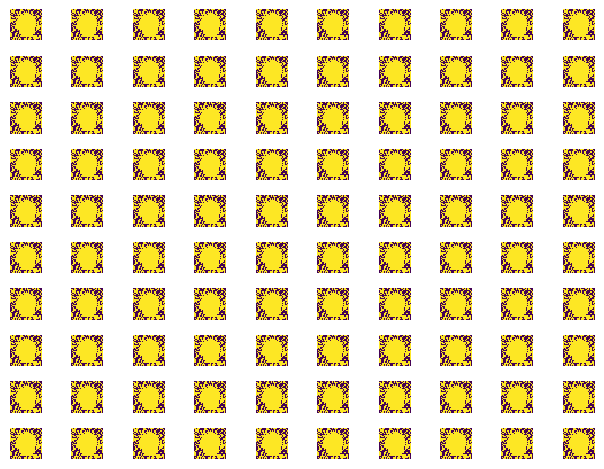

In [27]:
plot_image(g)